<a id='back_to_top'></a>

# Table of Content

- ### [Imports and Functions](#imports_n_functions)
- ### [Loading the features and data types](#loading_features)
- ### [Loading target and initial data analysis](#loading_target)
- ### [K - Means](#kmeans)
    

[back to top](#back_to_top)  <a id='imports_n_functions'></a>

In [312]:
import matplotlib
matplotlib.use('nbagg')

import os
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import scipy.stats as stats
import random
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator
import pandas as pd
import time
import seaborn as sb

In [2]:
# Set Pandas to display more columns as default
pd.options.display.max_columns=30

In [3]:
def read_data_from_pickle(file_name, sort = True, by_column = 'dim_user_gid'): 
    
    data = pd.read_pickle(file_name)
    data["dim_user_gid"].astype(int)

    print("\nA short summary of the uploaded file:")
    print("The data was loaded into a data-frame.")
    print("There are {} different rows, and {} different columns.".format(data.shape[0], data.shape[1]))
    print("There are {} unique values at the dim_user_gid column.".format(data['dim_user_gid'].nunique()))
    print("There are {} *nan* values at the dim_user_gid column.".format(data['dim_user_gid'].isnull().sum()))

    if sort:
        data = data.sort_values(by = ["dim_user_gid"])
        print("The data-frame was sorted by the dim_user_gid column.\n")
    
    return data

In [4]:
def find_users_in_both_data_and_target_frames(data_frame, target_frame, sort = True, by_column = 'dim_user_gid'):
    
    result = data_frame.join(target_frame.set_index('dim_user_gid'), how="inner")
    
    print("\nA short summary:")
    print("The target frame was merged with the historical data frame, and it includes *only* users that appears in both.")
    print("There are {} different rows, and {} different columns.".format(result.shape[0], result.shape[1]))
    print("There are {} *nan* values at the dim_user_gid column.".format((result.shape[0] - result['dim_user_gid'].count())))
    print("There are {} unique values at the dim_user_gid column.".format(result['dim_user_gid'].nunique()))
    
    result = result.drop_duplicates(subset=["dim_user_gid"], keep='last')
    if sort:
        result = result.sort_values(by = ['dim_user_gid'])
        
    print("\nKeeping only the last entry of each duplicate.\nThe end data frame has {} rows.".format(result.shape[0]))
    print("It was sorted by the dim_user_gid column.\n")
    
    return result

In [5]:
def hist_of_numerical_feature(data_frame, column, n_bins, figure_size = (10, 6)):

    x = data_frame[column].to_numpy()
    plt.figure(figsize=figure_size)
    n, bins, patches = plt.hist(x, bins=n_bins, edgecolor='black')
    ticks = 0.5 * np.diff(bins) + bins[:-1]
    plt.xticks(ticks, np.ceil(ticks))
    
    # after plotting the data, format the labels
    current_values = plt.gca().get_xticks()
    # using format string '{:.0f}' here but you can choose others
    plt.gca().set_xticklabels(['{:.0f}'.format(x) for x in current_values])
    plt.xticks(rotation=90)

    # Set x-axis label
    plt.xlabel(column, labelpad=20, size=16)
    plt.ylabel("Count", labelpad=20, size=16)
    sb.despine(top=True, right=True, left=False, bottom=False)

    plt.show()

In [6]:
def get_hist_info(x, n_bins): 
    
    n, bins, patches = plt.hist(x, bins=n_bins)
    plt.close()

    return n ,bins, patches

In [7]:
def plot_loglog_scale(data_frame, column, n_bins, figure_size = (10, 6)):

    x = data_frame[column].to_numpy()
    counts, bins, patches = get_hist_info(x, n_bins)
    bins_center = 0.5 * np.diff(bins) + bins[:-1]
    
    plt.figure(figsize=figure_size)
        
    plt.loglog(bins_center, counts, '.-')

    plt.xlabel('$log_{10}$' + '({}) '.format(column), labelpad=20, size=16)
    plt.ylabel('$log_{10}$ (counts) ', labelpad=20, size=16)
    sb.despine(top=True, right=True, left=False, bottom=False)
    
    plt.show()

In [8]:
def plot_data_by_index(data_frame, column, marker_size = 0.5, figure_size = (10, 6)): 
    
    plt.figure(figsize=figure_size)
    plt.plot(range(data_frame[column].shape[0]), data_frame[column], '.', markersize = marker_size)
    plt.xlabel('Index in Data', labelpad=20, size=16)
    plt.ylabel(column, labelpad=20, size=16)
    sb.despine(top=True, right=True, left=False, bottom=False)

    plt.show()

[back to top](#back_to_top)  <a id='loading_features'></a>

### Loading the features and data types

In [294]:
# # Data with 1 million users
# file_name = "Data/data_features_1_million_users_20220915.pkl"

# # Data with 5 million users
# file_name = "Data/data_features_5_million_users_20220915.pkl"

# Data with 5 million users that was cleaned in Part 1, and if the name suggests, may inlcude seniority 
# column as well
data_file_name = "Data/data_features_5_million_users_20220915_cleaned_with_Seniority.pkl"

In [10]:
data_for_clustering = read_data_from_pickle(data_file_name)
data_for_clustering.head(10)


A short summary of the uploaded file:
The data was loaded into a data-frame.
There are 4985297 different rows, and 27 different columns.
There are 4985297 unique values at the dim_user_gid column.
There are 0 *nan* values at the dim_user_gid column.
The data-frame was sorted by the dim_user_gid column.



dim_user_gid  est_seniority top_platform  level  trstier level_bracket  \
23899           261           3628        Apple   74.0      2.0      lv_40_79   
40151           288           3628       Google   77.0      1.0      lv_40_79   
40152           312           3628       Google   97.0      1.0     lv_80_119   
40153           376           3628       Google  126.0      3.0    lv_120_139   
68592           381           3628       Google  129.0      2.0    lv_120_139   
80781           388           3628        Apple   85.0      2.0     lv_80_119   
48277           391           3628          Web  243.0      2.0    lv_200plus   
3584            427           3628     Facebook  208.0      3.0    lv_200plus   
48278           436           3628     Facebook   72.0      2.0      lv_40_79   
68593           454           3628       Google   64.0      2.0      lv_40_79   

       is_elite  is_vip  llrecency  Lifetime_Revenue_Net  \
23899         0       0          4                0.0000   
40151         0       0          1                0.0000   
40152         0       0          1                0.0000   
40153         0       0         10               85.1555   
68592         0       0          1              110.9604   
80781         0       0        121                3.8430   
48277         0       0          1                0.0000   
3584          0       0          1                0.0000   
48278         0       0         41                0.0000   
68593         0       0         49                0.0000   

       Last_30D_Revenue_Net  Last_90D_Revenue_Net  Last_30D_Transactions  \
23899                   0.0                 0.000                      0   
40151                   0.0                 0.000                      0   
40152                   0.0                 0.000                      0   
40153                   0.0                10.493                      0   
68592                   0.0                10.493                      0   
80781                   0.0                 0.000                      0   
48277                   0.0                 0.000                      0   
3584                    0.0                 0.000                      0   
48278                   0.0                 0.000                      0   
68593                   0.0                 0.000                      0   

       Last_30D_Gross_Sink  Last_90D_Gross_Sink  Last_30D_Login_days  \
23899                 42.0                 42.0                    2   
40151                  0.0                  0.0                    6   
40152              16952.0              53355.0                   29   
40153                  0.0               2652.0                    1   
68592                450.0              25135.0                   10   
80781                  0.0                  0.0                    0   
48277              11580.0              34815.0                   30   
3584               21180.0             238137.0                   27   
48278                  0.0                772.0                    0   
68593                  0.0               1944.0                    0   

       Last_90D_Login_days  credits_balance_EOD  coins_balance_EOD  \
23899                    2              23992.0           989739.0   
40151                   17                591.0           129887.0   
40152                   89                279.0           485502.0   
40153                    7               2278.0          2863137.0   
68592                   36               5698.0          1277645.0   
80781                    0               1414.0             4238.0   
48277                   90                  4.0             4128.0   
3584                    87                426.0             9904.0   
48278                    1                204.0           342700.0   
68593                    1                207.0            25913.0   

       number_of_bingo_rounds  Life_Time_Login_Days  

As for the Kmeans we only use the numerical features for now, we do the following: 

In [316]:
# Loading the dict of the features data types and creating a list that includes only 
# the numerical features. 

dict_of_features_data_type_file_name = "Data/dict_of_features_data_type.txt"

with open(dict_of_features_data_type_file_name) as dict_of_features_data_type:
    columns_math_data_types = json.load(dict_of_features_data_type)

numerical_columns = [column for column in data_for_clustering.columns if column != 'dim_user_gid' and columns_math_data_types[column] == 'Numerical']

In [317]:
print(numerical_columns)

['level', 'llrecency', 'Lifetime_Revenue_Net', 'Last_30D_Revenue_Net', 'Last_90D_Revenue_Net', 'Last_30D_Transactions', 'Last_30D_Gross_Sink', 'Last_90D_Gross_Sink', 'Last_30D_Login_days', 'Last_90D_Login_days', 'credits_balance_EOD', 'coins_balance_EOD', 'number_of_bingo_rounds', 'Life_Time_Login_Days', 'total_rounds_mode_1', 'total_rounds_mode_2', 'total_rounds_mode_3', 'total_rounds_mode_4', 'total_rounds_mode_5', 'total_rounds_mode_6']


[back to top](#back_to_top)  <a id='loading_target'></a>

### Loading the revenue target and initial data analysis

In [11]:
target_file_name = "Data/data_target_revenue_20220916.pkl"

In [12]:
data_target_revenue = read_data_from_pickle(target_file_name)
data_target_revenue.head(10)


A short summary of the uploaded file:
The data was loaded into a data-frame.
There are 103211 different rows, and 2 different columns.
There are 51856 unique values at the dim_user_gid column.
There are 0 *nan* values at the dim_user_gid column.
The data-frame was sorted by the dim_user_gid column.



dim_user_gid revenue_converted_net
17184           600                2.9153
81484          1240                3.4930
85786          1307                0.6230
34537          1621               10.4930
72900          1788                6.2930
72899          1788                6.2930
72898          1788                6.2930
72897          1788                0.6930
72896          1788               10.4930
21602          2082               19.5930

In [13]:
# Calculating the total revenue of a given user (as a user might have had several purchase events in a day)
data_target_revenue['Total_revenue_at_day'] = data_target_revenue.groupby(['dim_user_gid'])['revenue_converted_net'].transform('sum').astype(float)

# Adding a column with the number of purchase events of a user
data_target_revenue['num_purchase_events_of_user'] = data_target_revenue.groupby('dim_user_gid')['dim_user_gid'].transform('size')

# Keeping just the information per a user id
data_target_revenue = data_target_revenue.drop_duplicates(subset=['dim_user_gid']).drop('revenue_converted_net', axis = 1)

data_target_revenue.head(10)

dim_user_gid  Total_revenue_at_day  num_purchase_events_of_user
17184           600                2.9153                            1
81484          1240                3.4930                            1
85786          1307                0.6230                            1
34537          1621               10.4930                            1
72900          1788               30.0650                            5
21602          2082               68.5510                            7
47251          2115               19.5965                            1
89753          2136                0.7184                            1
94256          2295               59.5080                            5
56186          2377                8.7777                            1

In [14]:
print("The shape of the target data frame is:\n{}".format(data_target_revenue.shape))
print("\nAnd the types of the data is:")
print(data_target_revenue.dtypes)

The shape of the target data frame is:
(51856, 3)

And the types of the data is:
dim_user_gid                     int64
Total_revenue_at_day           float64
num_purchase_events_of_user      int64
dtype: object


In [15]:
column = "Total_revenue_at_day"
print("There are {} **zeros** and {} **nan** in the {} column".format(len(data_target_revenue[data_target_revenue['Total_revenue_at_day'] == 0]), data_target_revenue[column].isnull().sum(), column))

There are 0 **zeros** and 0 **nan** in the Total_revenue_at_day column


The revenue data set only includes paying users.   
So in the clustering, it is expected that this users will be at only a few clusters -> as the vast majority of the users in the general population are non-paying users. 

So I expect a low spread of target among the clusters that will include the non-paying users, and a high spread among the cluster(s) that will include the paying users. Unless the clustering is done on only paying users. 

<IPython.core.display.Javascript object>


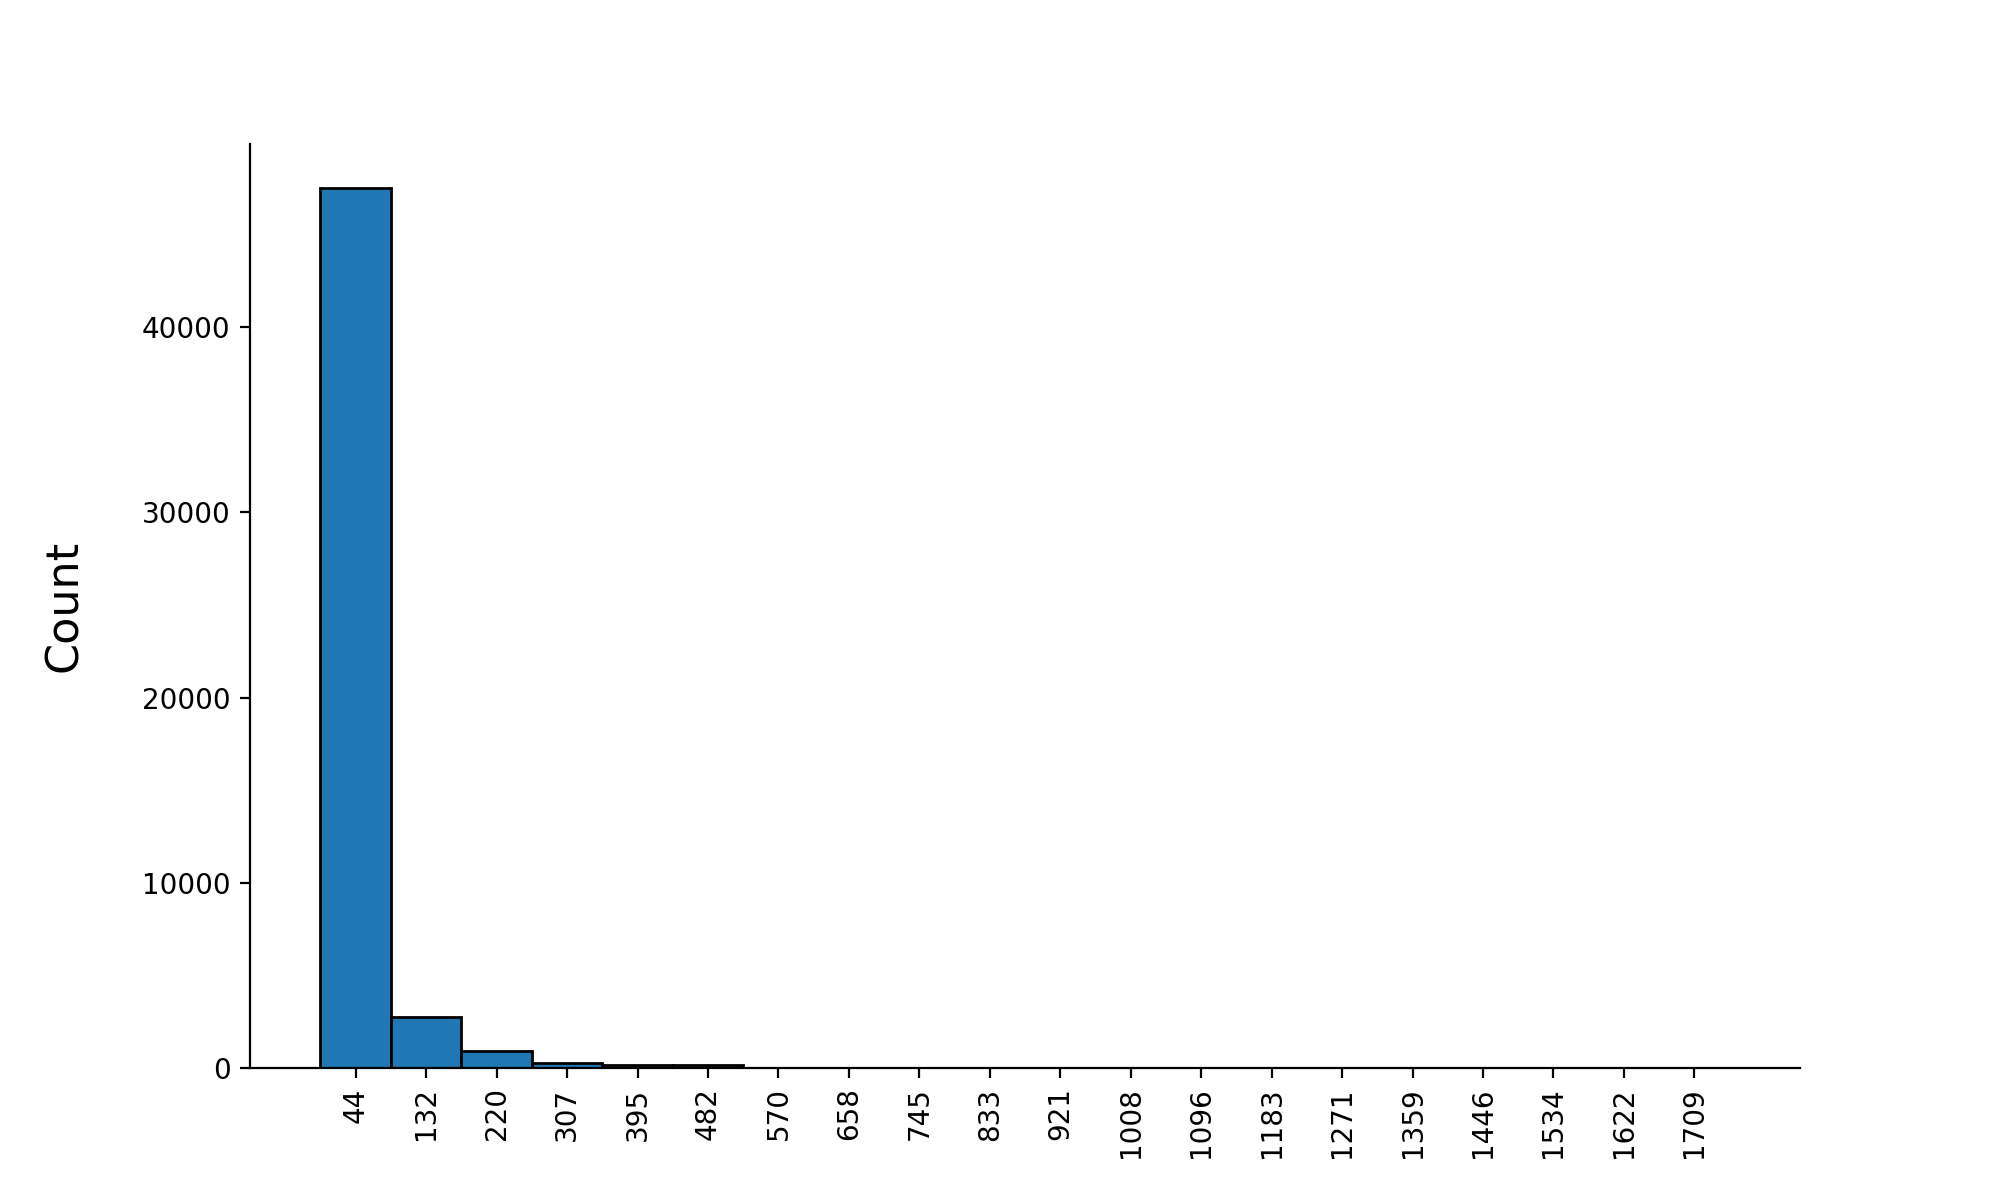

In [16]:
n_bins = 20
hist_of_numerical_feature(data_target_revenue, 'Total_revenue_at_day', n_bins)

<ipython-input-6-207e611714e3>:4: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


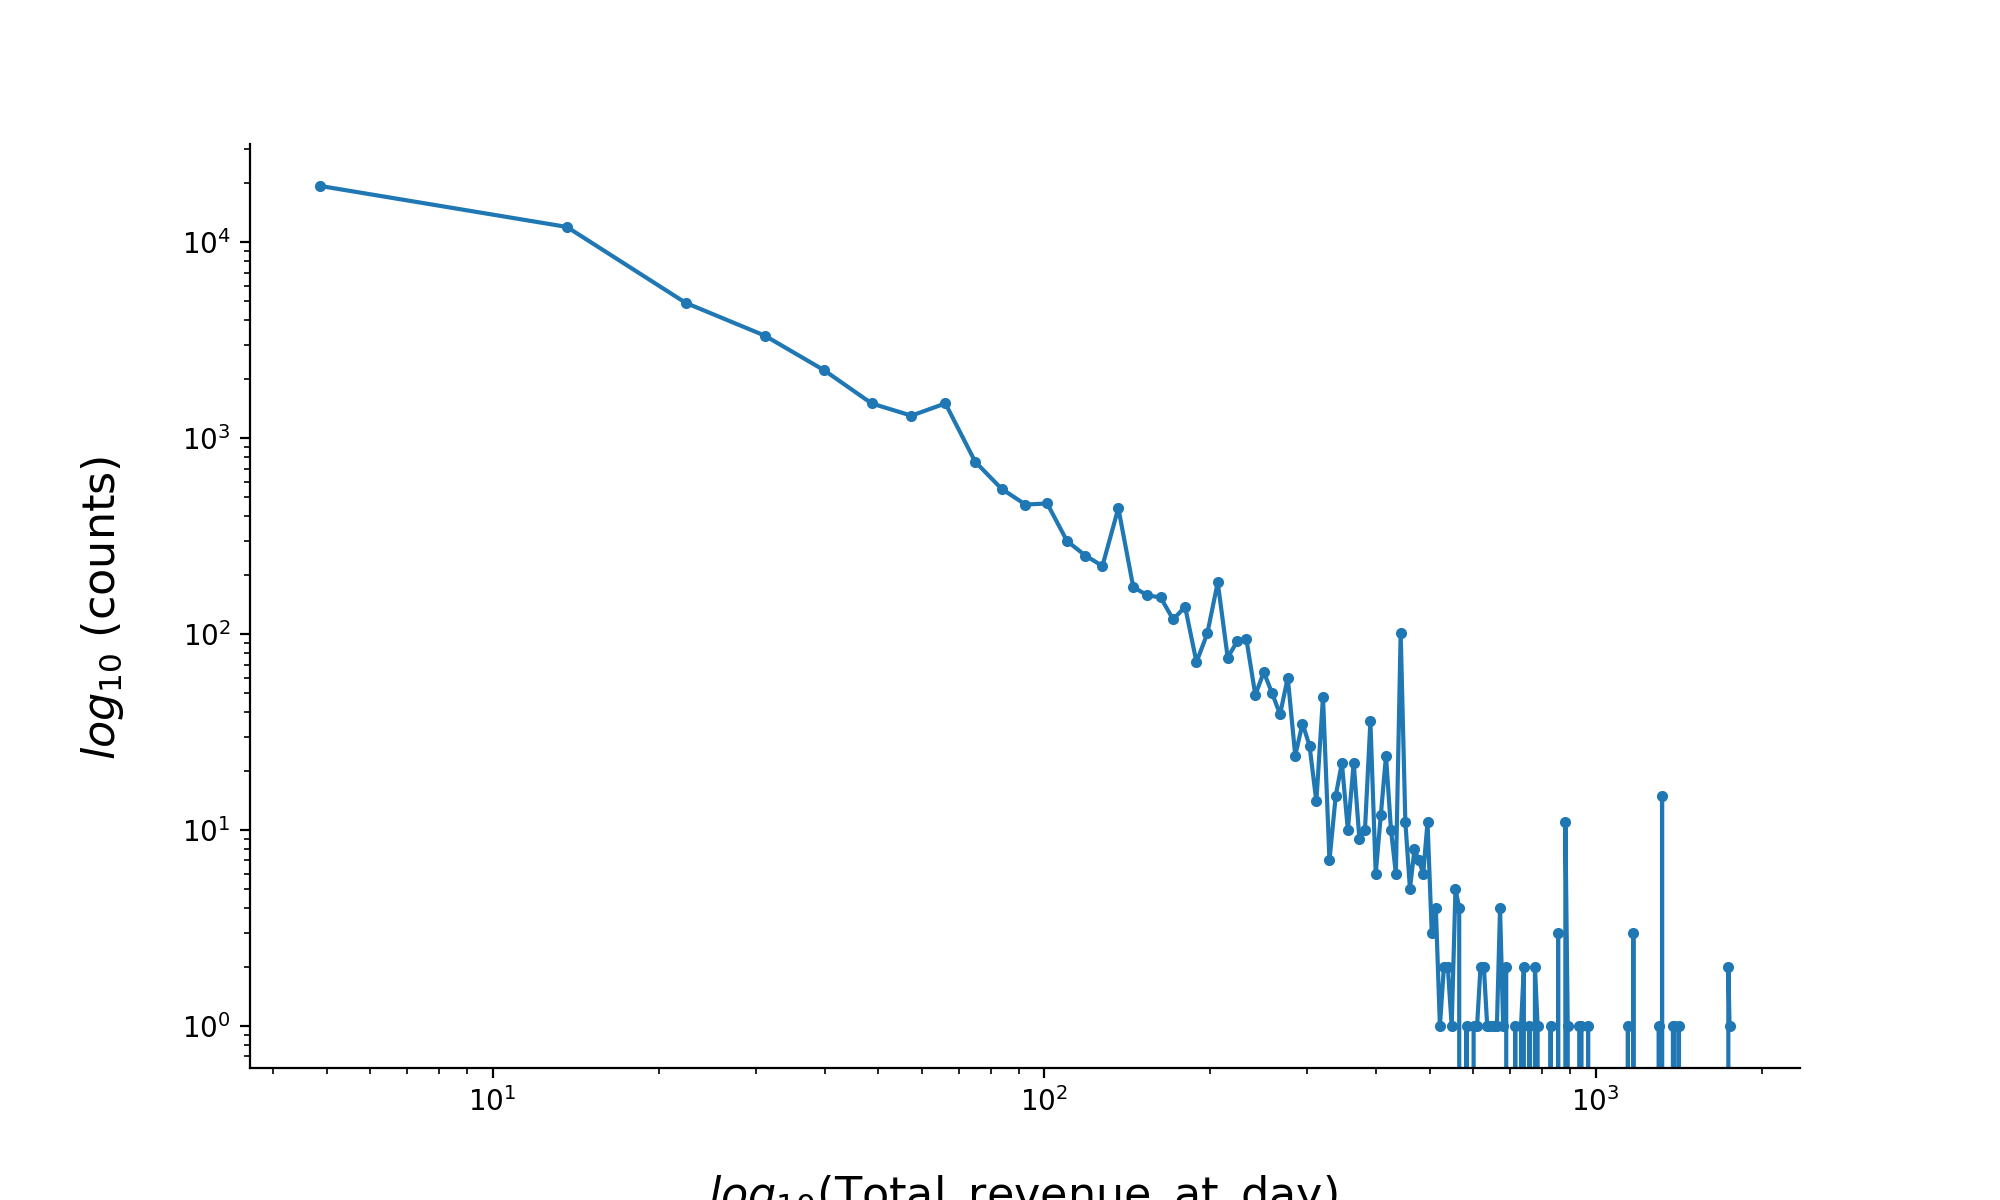

In [17]:
n_bins = 200
plot_loglog_scale(data_target_revenue, 'Total_revenue_at_day', n_bins)

The distribution of the revenue seems power-law even from a day of data. 

<IPython.core.display.Javascript object>


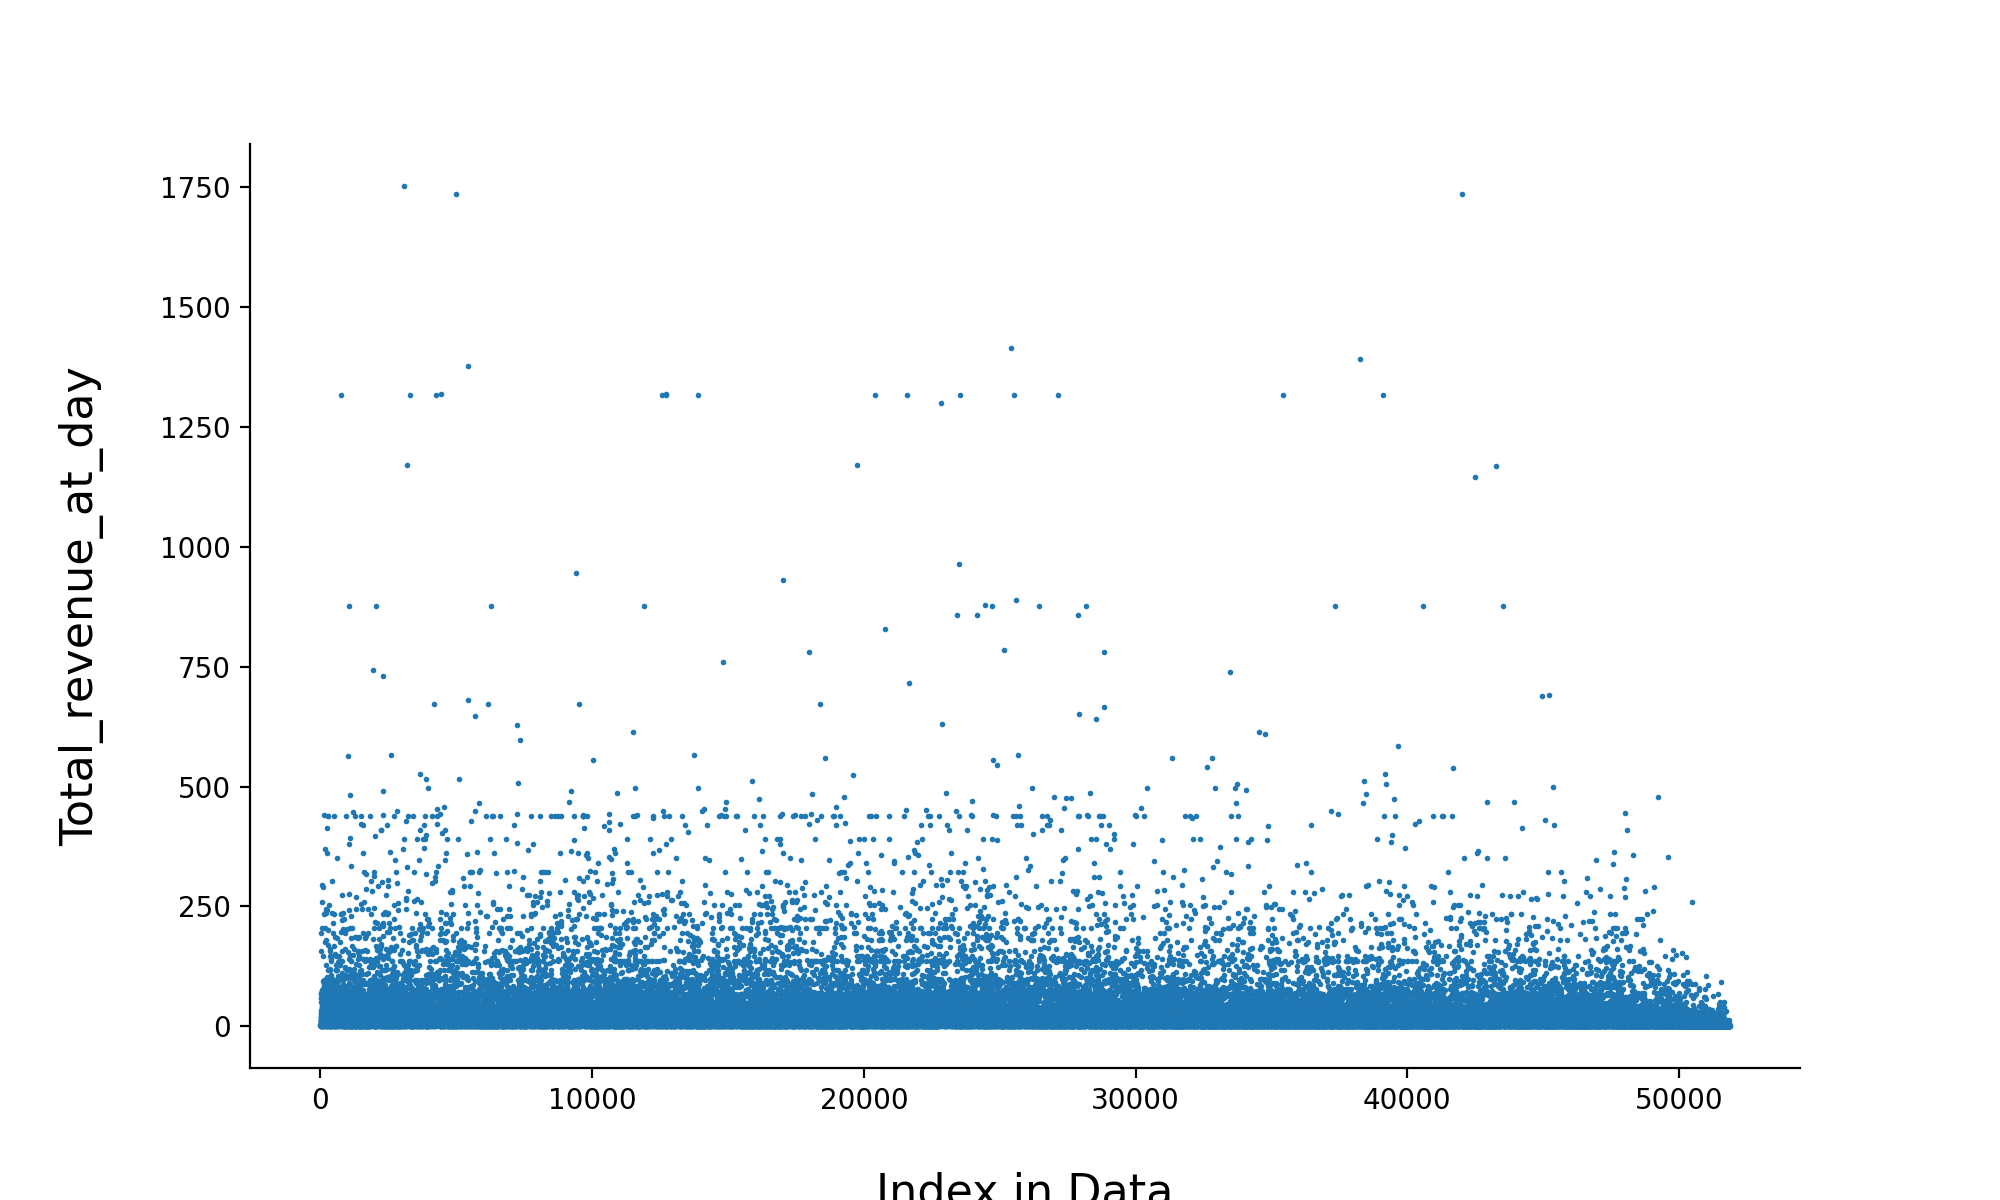


The lowest user id is: 600

and the highest user id is: 1004641327


In [18]:
marker_size = 2
plot_data_by_index(data_target_revenue, 'Total_revenue_at_day', marker_size)

print("\nThe lowest user id is: {}".format(data_target_revenue["dim_user_gid"].iloc[0]))
print("\nand the highest user id is: {}".format(data_target_revenue["dim_user_gid"].iloc[-1]))

<IPython.core.display.Javascript object>


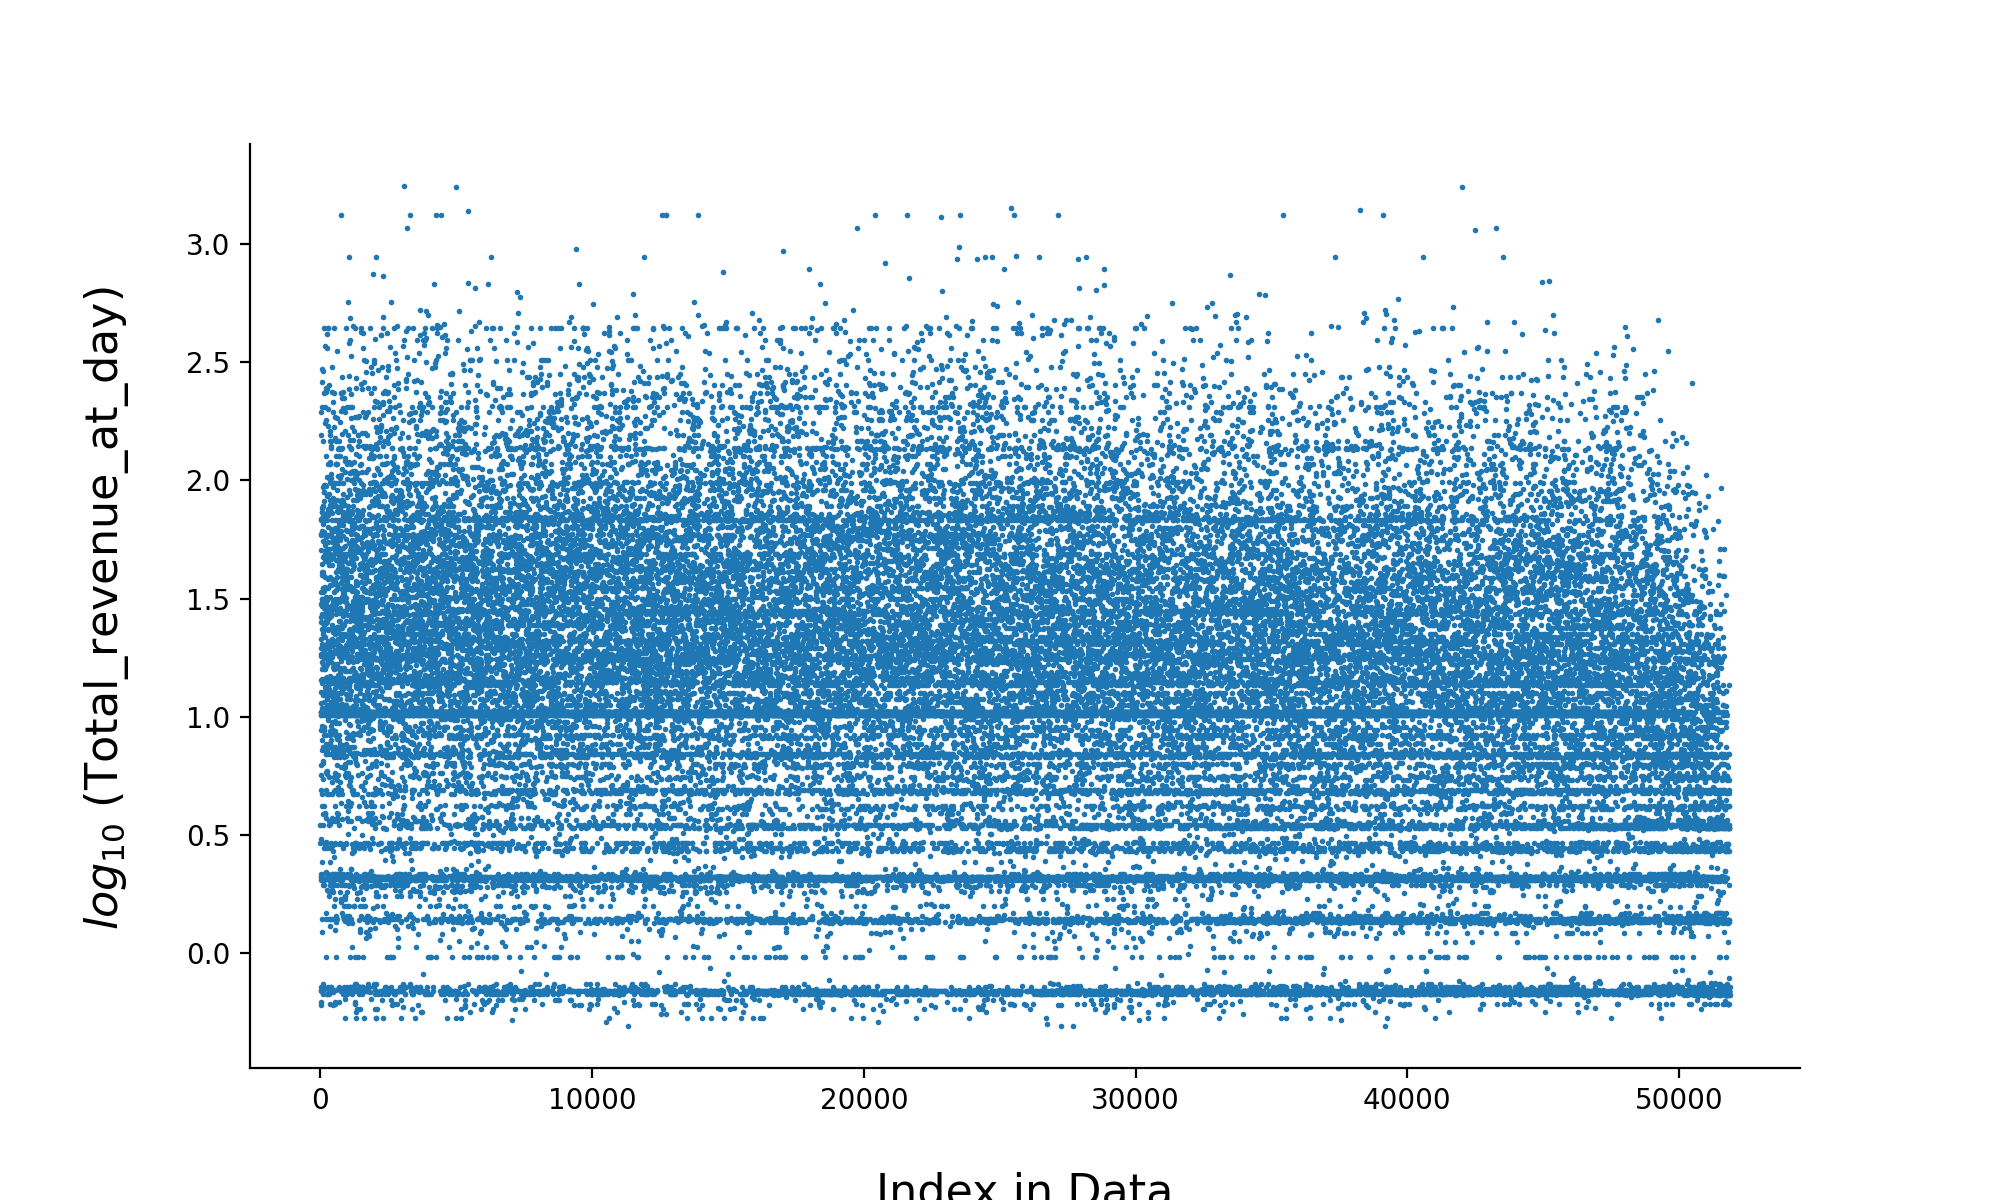

In [19]:
# And when the revenue is in log scale
plt.figure(figsize=(10,6))
plt.plot(range(data_target_revenue["dim_user_gid"].shape[0]), np.log10(data_target_revenue["Total_revenue_at_day"]), '.', markersize = marker_size)
plt.xlabel('Index in Data', labelpad=20, size=16)
plt.ylabel('$log_{10}$ (Total_revenue_at_day) ', labelpad=20, size=16)
sb.despine(top=True, right=True, left=False, bottom=False)

plt.show()

<IPython.core.display.Javascript object>


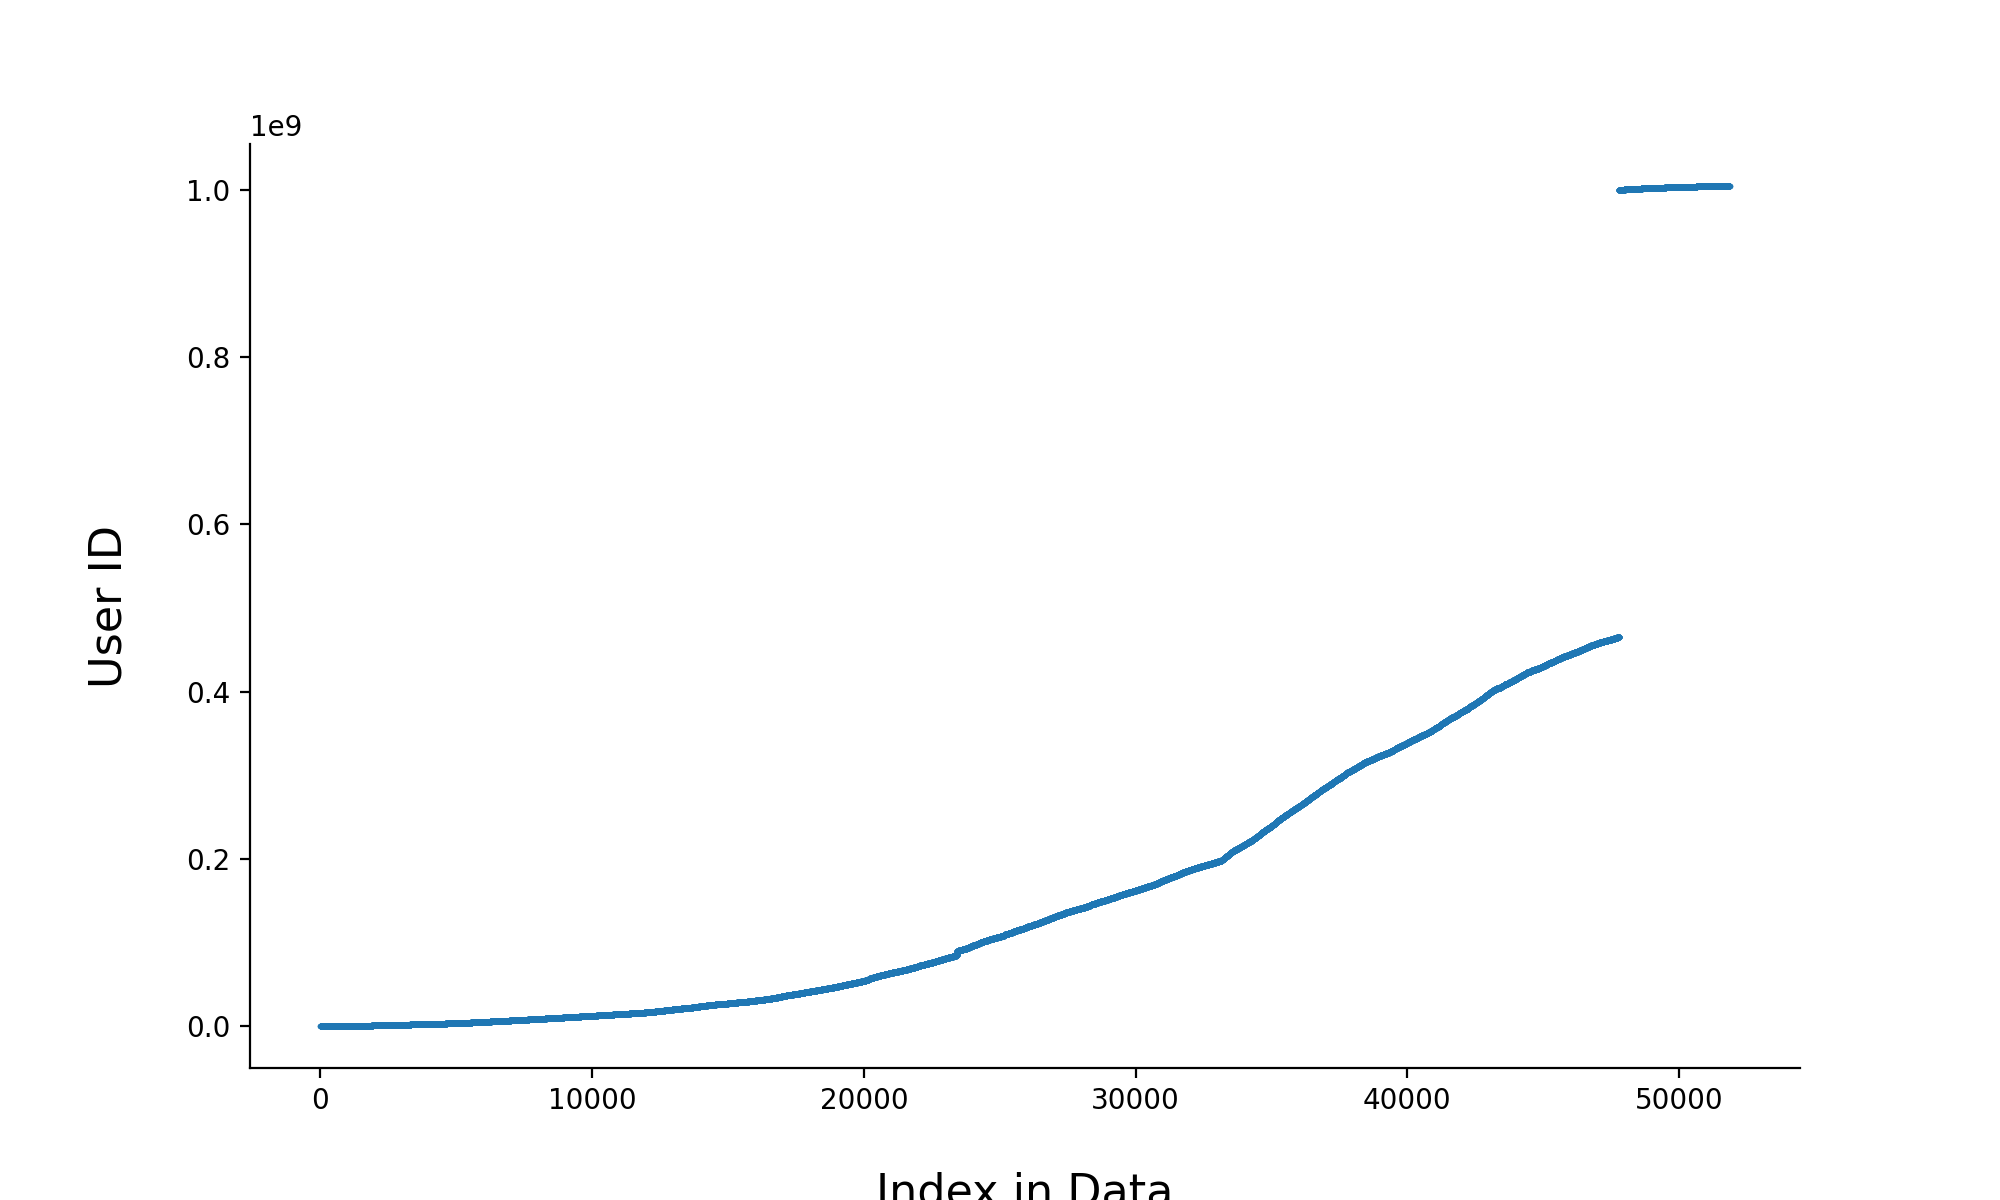

In [20]:
plt.figure(figsize=(10,6))
plt.plot(range(data_target_revenue["dim_user_gid"].shape[0]), data_target_revenue["dim_user_gid"], '.', markersize = marker_size)
plt.xlabel('Index in Data', labelpad=20, size=16)
plt.ylabel("User ID", labelpad=20, size=16)
sb.despine(top=True, right=True, left=False, bottom=False)

plt.show()

An initial analysis (part 1) suggests that the revenue depends on the seniority of the users. Here we see that although there exist a wide range of users IDs, which suggest a spread in seniority, the daily revenue seems independent of that (see figure in previous cell), at least up to the last group of users with very high numbers, that are seperated from the other users in this graph, and have lower average revenue in the above graph. 

[back to top](#back_to_top)  <a id='kmeans'></a>

# K - Means 

In [333]:
def slicing_df_for_clustering(data, 
                              numerical_columns, 
                              num_of_features = 3, 
                              features = [], 
                              print_to_screen = False):

    if len(features):
        # Slicing the data with the given features
        sliced_data_for_clustering = data[features].copy()

    else: 
        # Or, randomly choosing features from the data. 
        features = randomly_choose_features(numerical_columns, num_of_features)
        sliced_data_for_clustering = data[features].copy()
            
    # The following column must be included in any sliced data frame for the clustering
    sliced_data_for_clustering.insert(0, 'dim_user_gid', data['dim_user_gid'])
    
    if print_to_screen: 
        print("The chosen features are: {}\n".format(features))
        print("The data frame for the clustering has the following shape:\n{}".format(sliced_data_for_clustering.shape))
        print()
        print("A quick view of it:\n")
        print(sliced_data_for_clustering.head(10))

    return sliced_data_for_clustering

In [323]:
def randomly_choose_features(numerical_columns, num_of_features = 3):
    
    if num_of_features == len(numerical_columns):
        return features_list
    
    elif num_of_features < 2:
        print("\n\nWarning!! The number of features to be randomly chosen should be at least 2!!")
        print("Returning an empty list.\n\n")
        return []
    
    else: 
        features_for_clustering = random.choices(numerical_columns, k = num_of_features)
        
    
    return features_for_clustering

In [318]:
# features_for_clustering = randomly_choose_features(numerical_columns)
# print(features_for_clustering)

In [334]:
# For random choice, how many features to cluster over: 
number_of_features = 4  # default is 3. 
# # Or, provide a list, like: 
# features = ['level', 'Last_30D_Revenue_Net', 'credits_balance_EOD']

sliced_data_for_clustering = slicing_df_for_clustering(data_for_clustering, 
                                                       numerical_columns, 
                                                       print_to_screen = True)

The chosen features are: ['Life_Time_Login_Days', 'total_rounds_mode_1', 'Last_90D_Gross_Sink']

The data frame for the clustering has the following shape:
(4985297, 4)

A quick view of it:

       dim_user_gid  Life_Time_Login_Days  total_rounds_mode_1  \
23899           261                    72                    0   
40151           288                    66                    0   
40152           312                   136                    0   
40153           376                   306                    0   
68592           381                   307                    0   
80781           388                   109                    0   
48277           391                  2480                    5   
3584            427                  1164                    0   
48278           436                   165                    0   
68593           454                    66                    0   

       Last_90D_Gross_Sink  
23899                 42.0  
40151                  0

In [335]:
def create_df_for_kmeans(data, 
                         log_features,
                         num_of_points, 
                         segment,
                         fraction,
                         log,
                         random, 
                         by_fraction, 
                         print_info):
    
    """ 
    Creating the data for the Kmeans clustering. 
    Including the option to transform the data from linear to log scale, and then make sure that the data has no 
    zero values. 
    
    In addition, as running the clustering over millions of users could take too long, there are several 
    options for choosing the users to cluster over. 
    1. Use the sample function - get random set of rows (users)
    as an example: X = df.sample(frac = 0.35) randomly chooses 35% of the data. 
                   X = df.sample(n = 1000) randomly chooses 1000 users. 
    
    2. By specific index of rows, either non-consecutive, or consecutive
    
    """
    
    # Choosing a subset of users from the data set. Either by slicing the data frame, or by randomly sampling
    # from it. 
    if not random: 
        X = data.iloc[(num_of_points*segment):(num_of_points*(segment+1)), :]
        # Or: 
        # # X = data.iloc[[k for k in range(num_of_points*segment, num_of_points*(segment+1))], :]
        
    else: 
        if by_fraction:
            X = data.sample(frac = fraction) # randomly chooses frac = fraction of the data. 
        else:
            X = data.sample(n = num_of_points) # randomly chooses num_of_points users. 
            
    if log: 
        X[X <= 0] = 0.01  # avoiding errors due to log of negative or zeros. 
        if log_features == "all":
            for column in X.columns:
                if column != 'dim_user_gid':
                    X[column] = np.log10(X[column])
        
        else:
            for column in log_features:
                X[column] = np.log10(X[column]) 
        
        # There shouldn't be nan values in the data after the log transform, as the negative and zero
        # valued elements are set to a positive value. But checking just in case. 
        # If nan do exist, there is the need to figure out the source, and then find 
        # the appropriate solution. 
        check_for_nans(X, after_log_transform = True)

    if print_info:
        print("The shape of the data frame used for the clustering is:\n{}".format(X.shape))
        print("\nThe types of the columns are:")
        print(X.dtypes)
    
    return X

In [267]:
def check_for_nans(data, after_log_transform = False):
    
    counter = 0
    for column in data.columns: 
        if data[column].isnull().values.any():
            print("\n\nWarning!! There are suspected **nan** values in column: {}".format(column))
            if after_log_transform:
                print("after the log transform.")
            print("Please take care of that! \n\n")
            counter += 1
            
    if counter == 0: 
        if after_log_transform:
            print("\nNo **nan** values in the data frame for clustering after the log transform. Please continue.\n")
        else: 
            print("\nNo **nan** values in the data frame for clustering. Please continue.\n")            

In [277]:
log_features = "all"  # or a list of the features to log transform
log = True

num_of_points = 100000
segment = 1

random = False  # to choose the subset of users randomly.
by_fraction = True
fraction = 0.1
 
print_info = True

In [336]:
X = create_df_for_kmeans(sliced_data_for_clustering, 
                         log_features,
                         num_of_points, 
                         segment,
                         fraction,
                         log,
                         random, 
                         by_fraction, 
                         print_info)
X.head(10)


No **nan** values in the data frame for clustering after the log transform. Please continue.

The shape of the data frame used for the clustering is:
(498530, 4)

The types of the columns are:
dim_user_gid              int64
Life_Time_Login_Days    float64
total_rounds_mode_1     float64
Last_90D_Gross_Sink     float64
dtype: object


dim_user_gid  Life_Time_Login_Days  total_rounds_mode_1  \
1880825     397089754              2.526339            -2.000000   
4574772     460081639              0.000000            -2.000000   
992099       49853776              1.518514            -2.000000   
2740065     448263367              0.602060            -2.000000   
1384895     317946241              0.477121            -2.000000   
1473955     346899778              2.045323            -2.000000   
4960380     462538297              0.000000            -2.000000   
1151310     264718413              3.009876             1.579784   
2391512     439338724              1.380211            -2.000000   
3321814     451472563              0.301030            -2.000000   

         Last_90D_Gross_Sink  
1880825             5.033392  
4574772            -2.000000  
992099             -2.000000  
2740065            -2.000000  
1384895            -2.000000  
1473955             3.780317  
4960380            -2.000000  
1151310             4.845836  
2391512            -2.000000  
3321814            -2.000000

In [184]:
# kmeans_kwargs = {
#                 "init": "random",
#                 "n_init": 10,
#                 "random_state": 42,
#                 }

In [337]:
kmeans_kwargs = {
                "init": "k-means++",
                "n_init": 50,
                "max_iter": 500,
                "random_state": 42,
                }

In [339]:
sse = []
silhouette_coefficients = []

# A flag for whether to calculate the silhouette, as it takes quite some time for large data set.
calc_silhouette = False

for k in range(1, 11):
    print(k)
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X.drop(columns = ['dim_user_gid']))
    sse.append(kmeans.inertia_)
    
    if k > 1 and calc_silhouette:
        score = silhouette_score(X.drop(columns = ['dim_user_gid']), kmeans.labels_)
        silhouette_coefficients.append(score)

1
2
3
4
5
6
7
8
9
10


<IPython.core.display.Javascript object>


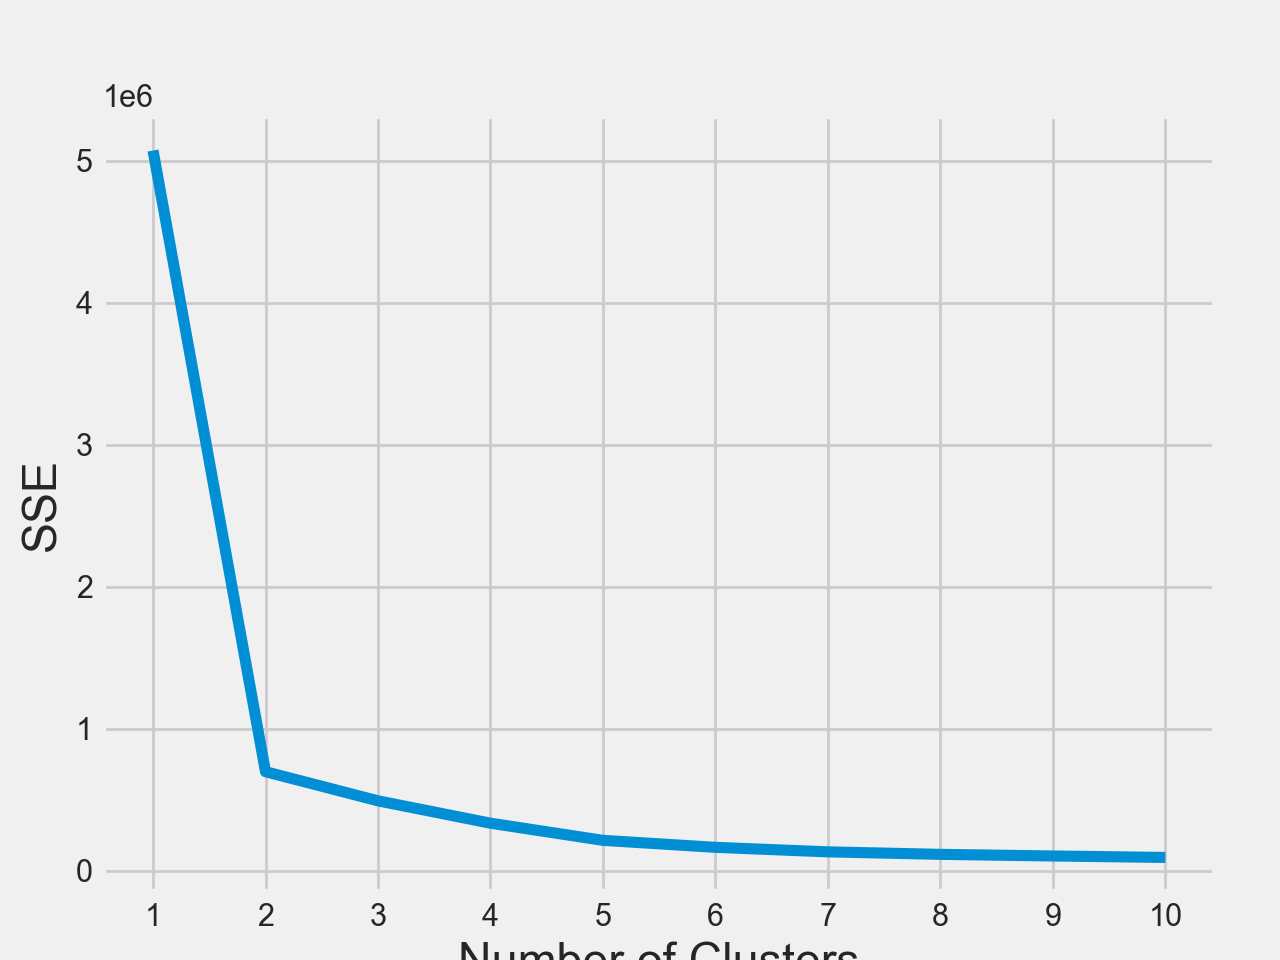

In [340]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [341]:
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
print("The preferred number of clusters is: {}.".format(kl.elbow))

The preferred number of clusters is: 2.


<IPython.core.display.Javascript object>


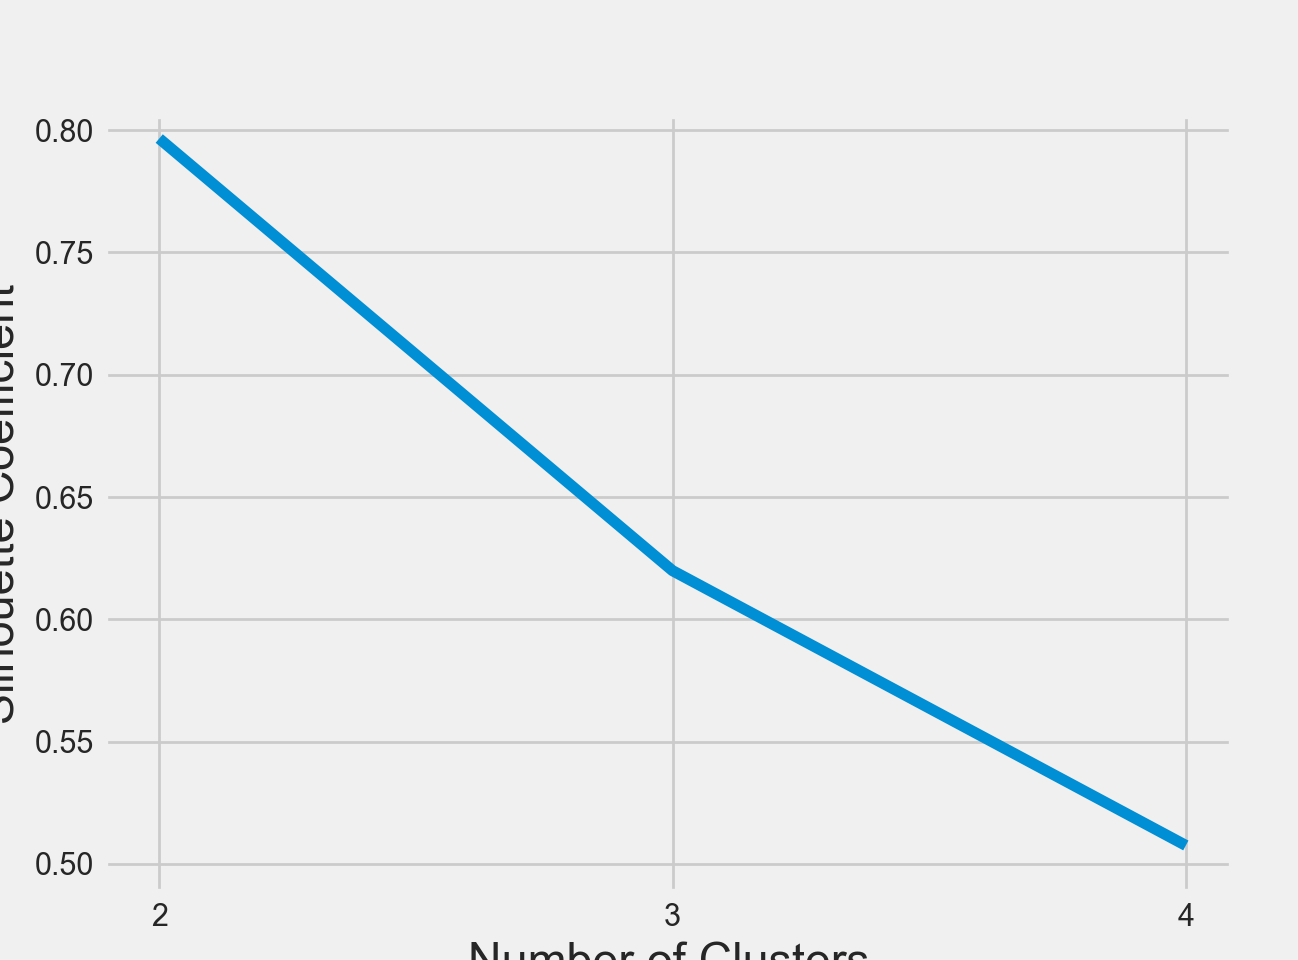

In [172]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 5), silhouette_coefficients)
plt.xticks(range(2, 5))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [342]:
# Create cluster feature

num_of_clusters = 6

start_time = time.time()
kmeans = KMeans(n_clusters=num_of_clusters, **kmeans_kwargs)
X["Cluster"] = kmeans.fit_predict(X.drop(columns = ['dim_user_gid']))
X["Cluster"] = X["Cluster"].astype("category")
end_time = time.time()

print("The Kmeans calculation for {} dimensions and {} rows was:\n{}sec".format(X.shape[1], X.shape[0], end_time - start_time))

X.head()

The Kmeans calculation for 5 dimensions and 498530 rows was:
11.319708108901978sec


dim_user_gid  Life_Time_Login_Days  total_rounds_mode_1  \
1880825     397089754              2.526339                 -2.0   
4574772     460081639              0.000000                 -2.0   
992099       49853776              1.518514                 -2.0   
2740065     448263367              0.602060                 -2.0   
1384895     317946241              0.477121                 -2.0   

         Last_90D_Gross_Sink Cluster  
1880825             5.033392       2  
4574772            -2.000000       0  
992099             -2.000000       4  
2740065            -2.000000       0  
1384895            -2.000000       0

<IPython.core.display.Javascript object>


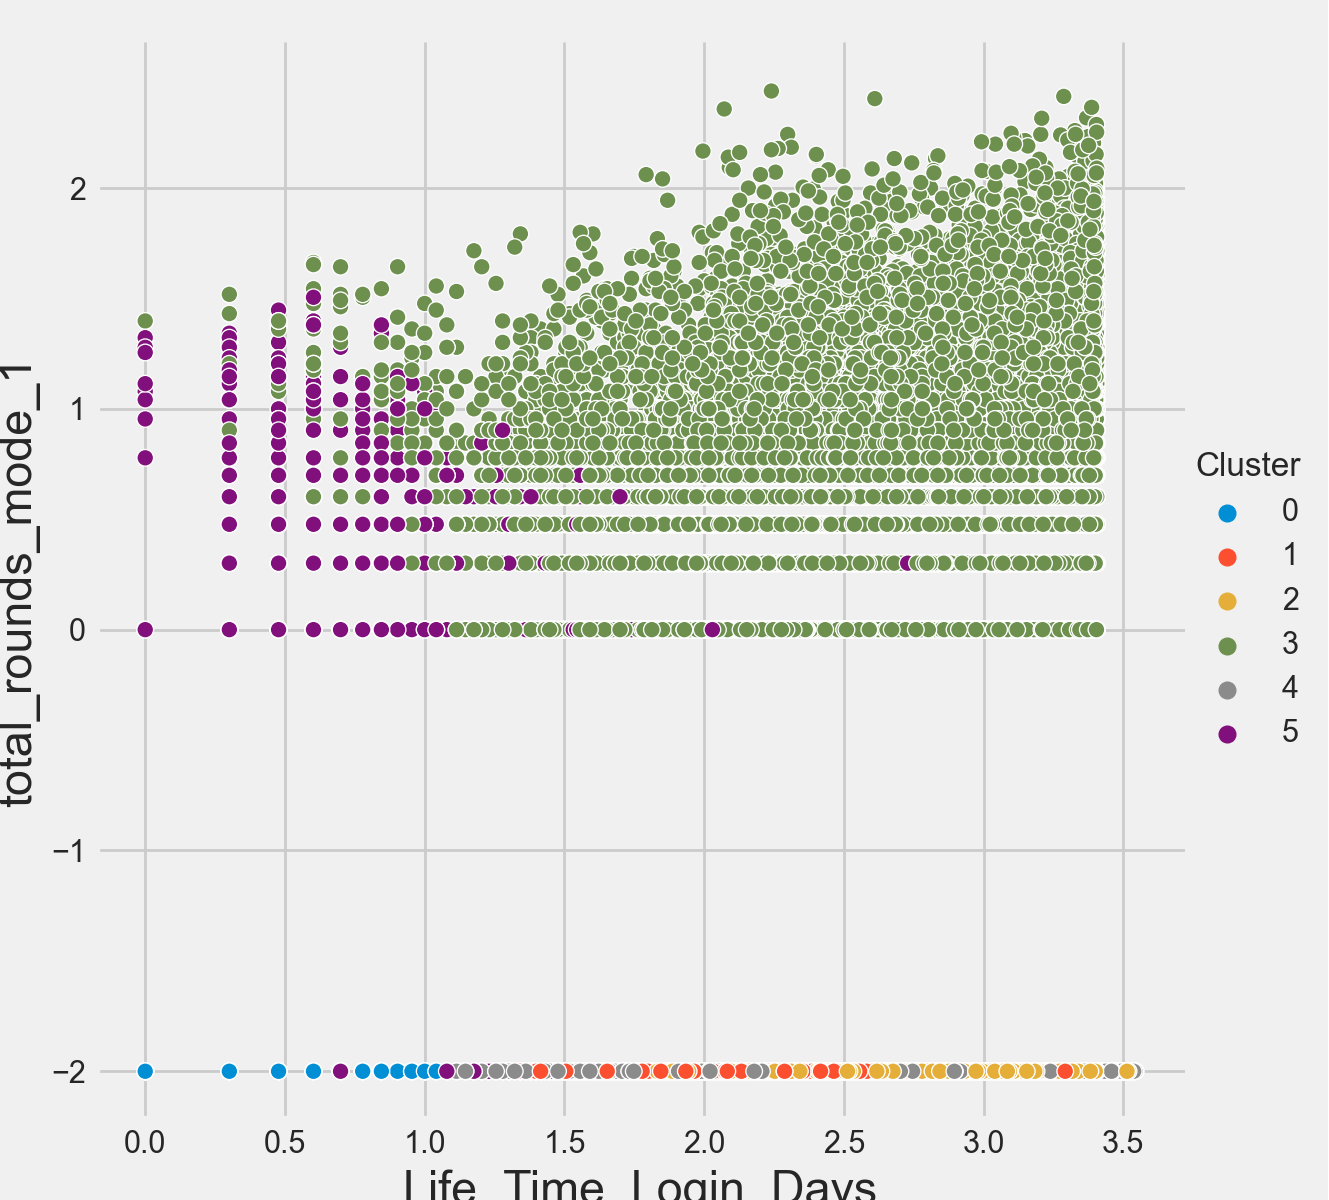

In [345]:
sb.relplot(
    x=X.columns[1], y=X.columns[2], hue="Cluster", data=X, height=6)

plt.show()

<IPython.core.display.Javascript object>


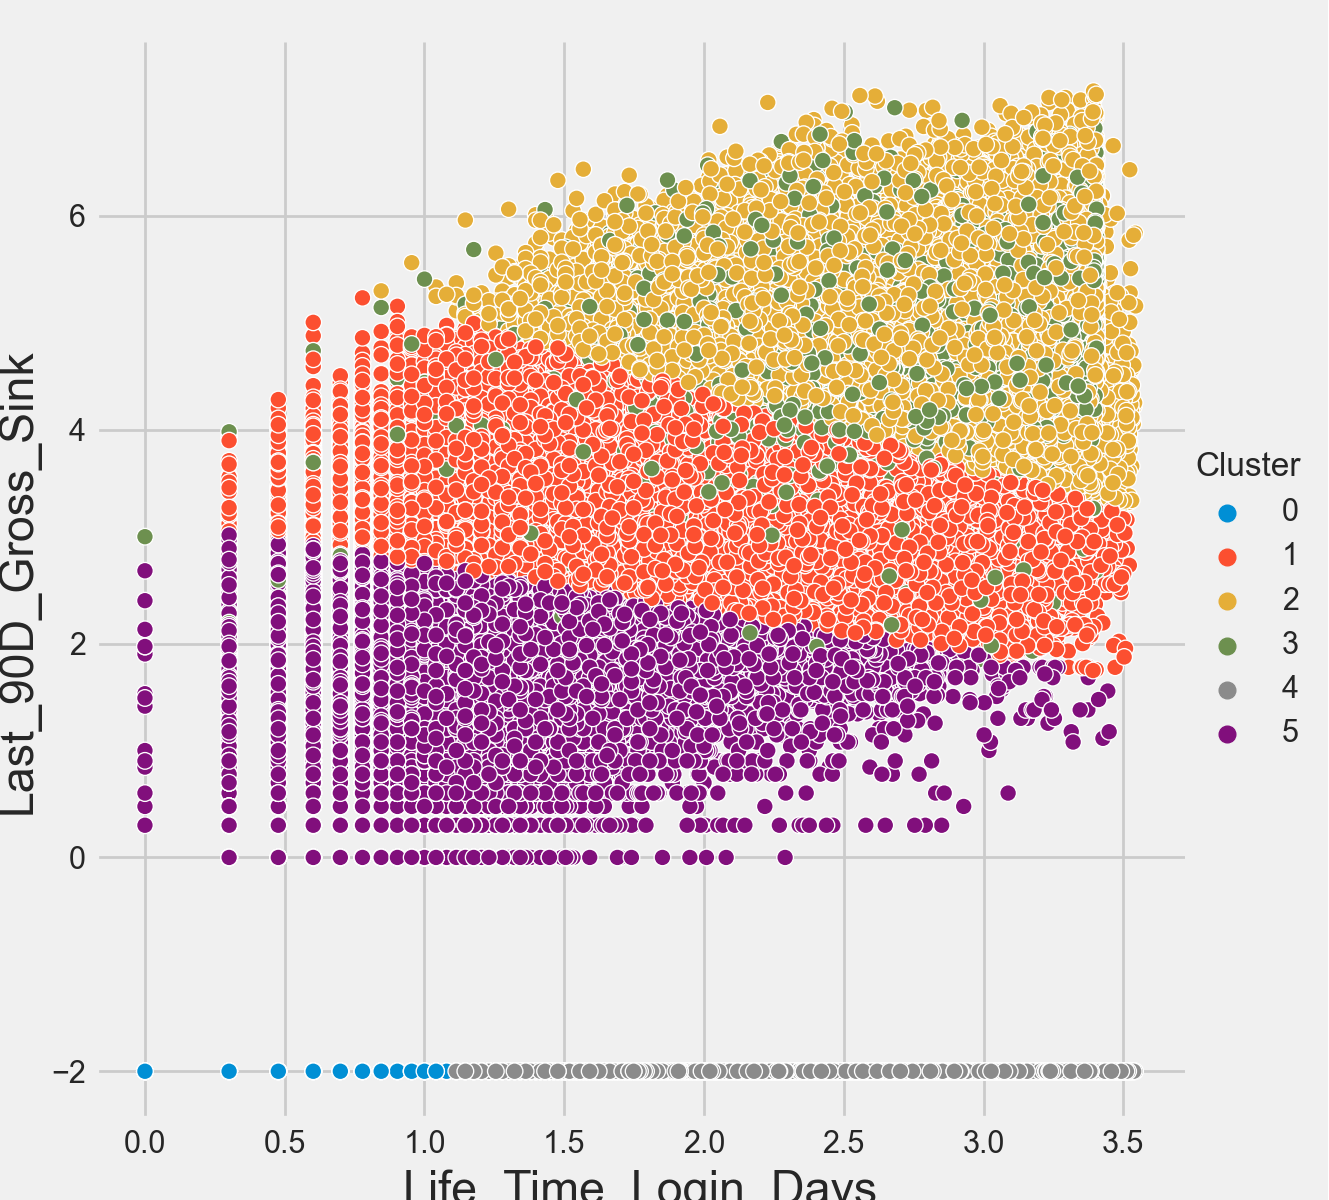

In [347]:
sb.relplot(
    x=X.columns[1], y=X.columns[3], hue="Cluster", data=X, height=6)

plt.show()

<IPython.core.display.Javascript object>


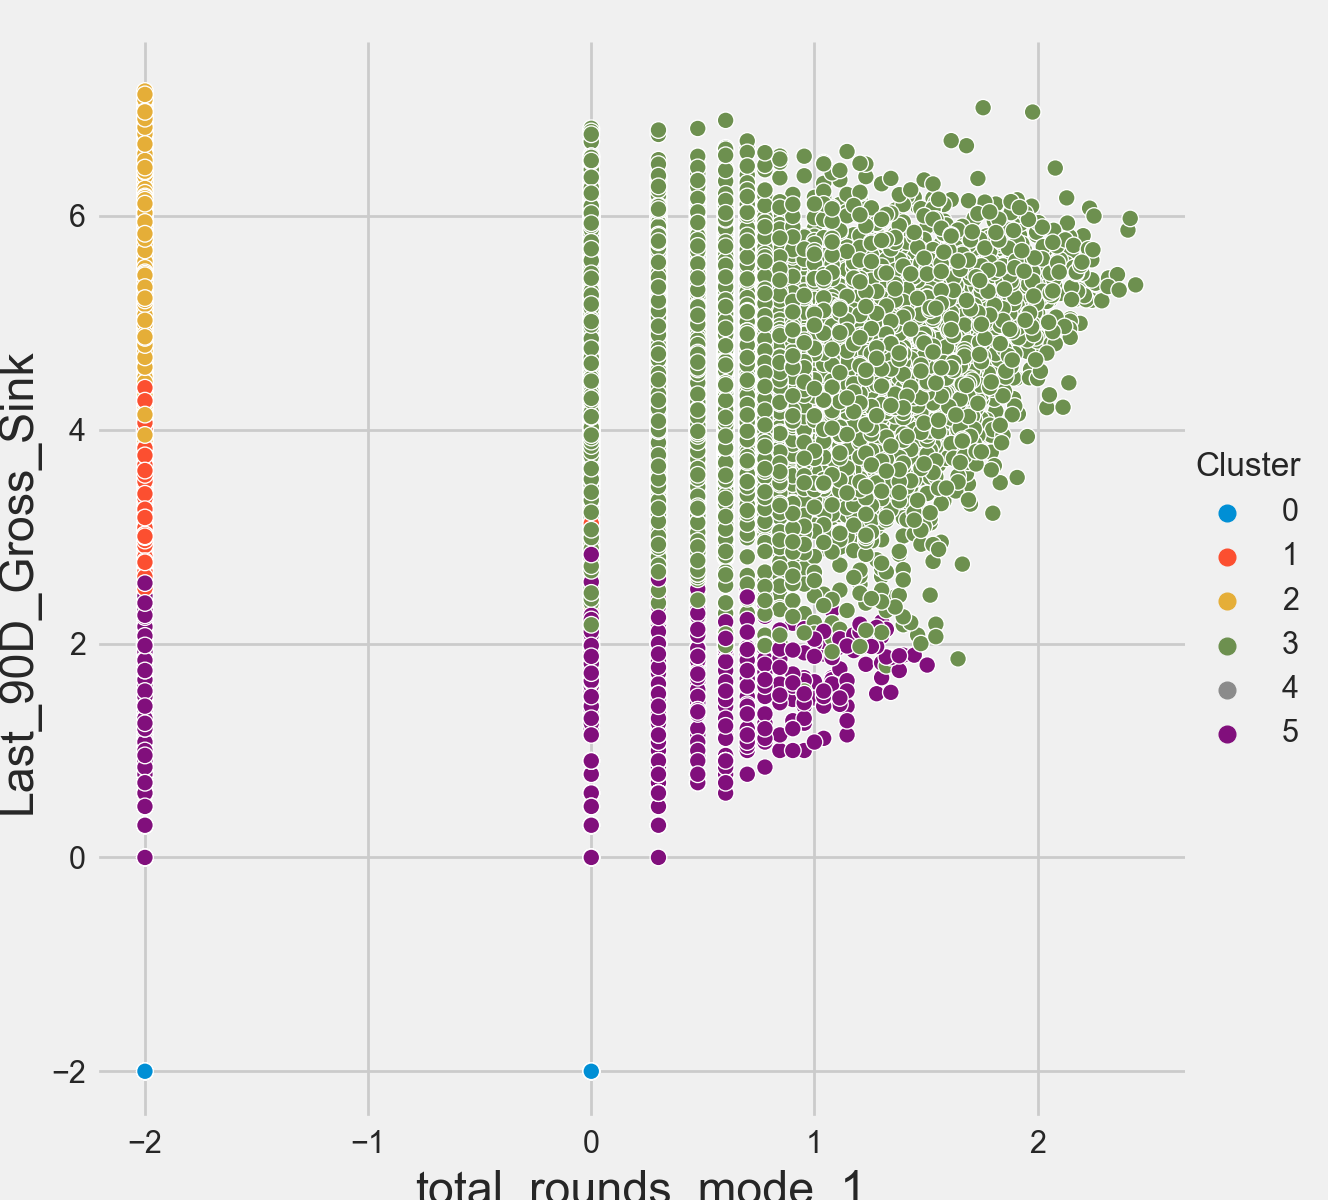

In [348]:
sb.relplot(
    x=X.columns[2], y=X.columns[3], hue="Cluster", data=X, height=6)

plt.show()

<IPython.core.display.Javascript object>


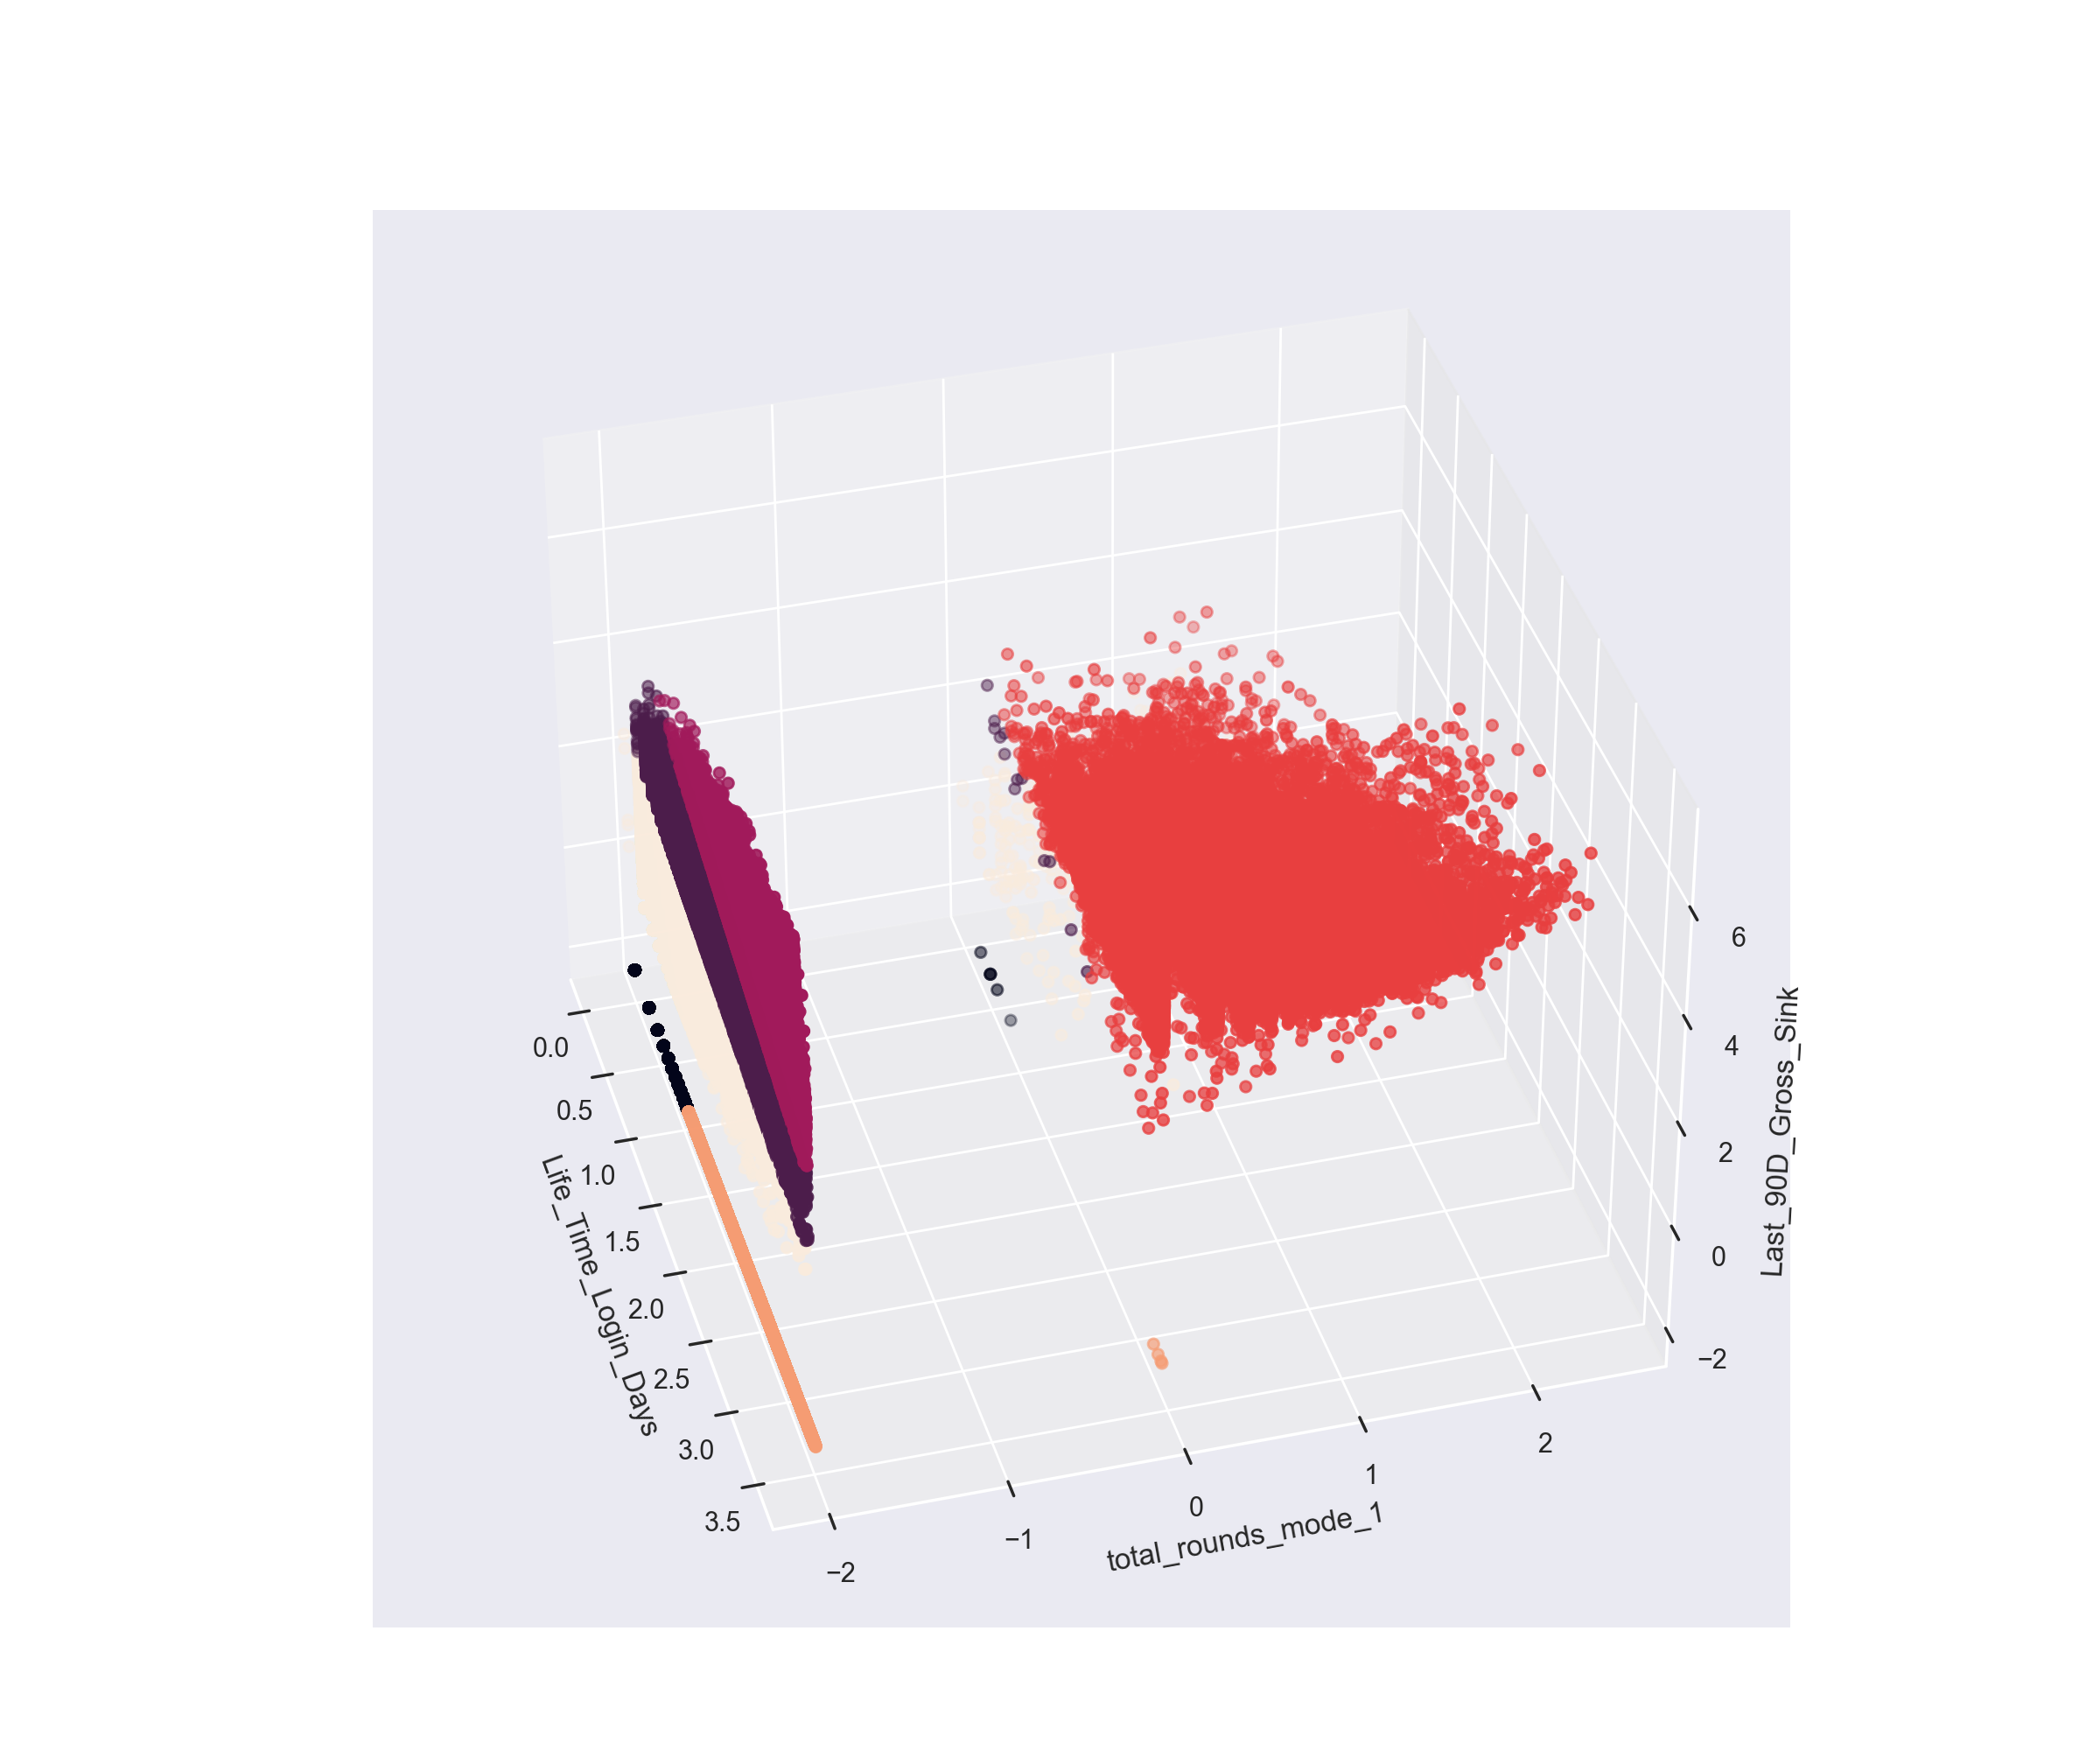

In [354]:
sb.set(style = "darkgrid")

fig = plt.figure(figsize = (12, 10))
ax = Axes3D(fig)
ax = fig.add_subplot(111, projection = '3d')

x = X.iloc[:, [1]]
y = X.iloc[:, [2]]
z = X.iloc[:, [3]]

ax.set_xlabel(X.columns[1])
ax.set_ylabel(X.columns[2])
ax.set_zlabel(X.columns[3])

ax.scatter(x, y, z, c = X['Cluster'])

plt.show()

In [355]:
X_merged_with_target = find_users_in_both_data_and_target_frames(X, data_target_revenue)


A short summary:
The target frame was merged with the historical data frame, and it includes *only* users that appears in both.
There are 556 different rows, and 7 different columns.
There are 0 *nan* values at the dim_user_gid column.
There are 556 unique values at the dim_user_gid column.

Keeping only the last entry of each duplicate.
The end data frame has 556 rows.
It was sorted by the dim_user_gid column.



In [356]:
X_merged_with_target.head()

dim_user_gid  Life_Time_Login_Days  total_rounds_mode_1  \
3598           3401              3.250420            -2.000000   
8126         130582              3.300378             1.113943   
69206        181061              1.792392            -2.000000   
89578        192264              2.785330            -2.000000   
73341        207230              2.406540            -2.000000   

       Last_90D_Gross_Sink Cluster  Total_revenue_at_day  \
3598              4.256862       2               10.1933   
8126              4.747474       3               14.5118   
69206             3.354108       1                4.6965   
89578             3.578868       1               27.9930   
73341             5.755444       2               10.1933   

       num_purchase_events_of_user  
3598                             1  
8126                             1  
69206                            1  
89578                            1  
73341                            1

<IPython.core.display.Javascript object>


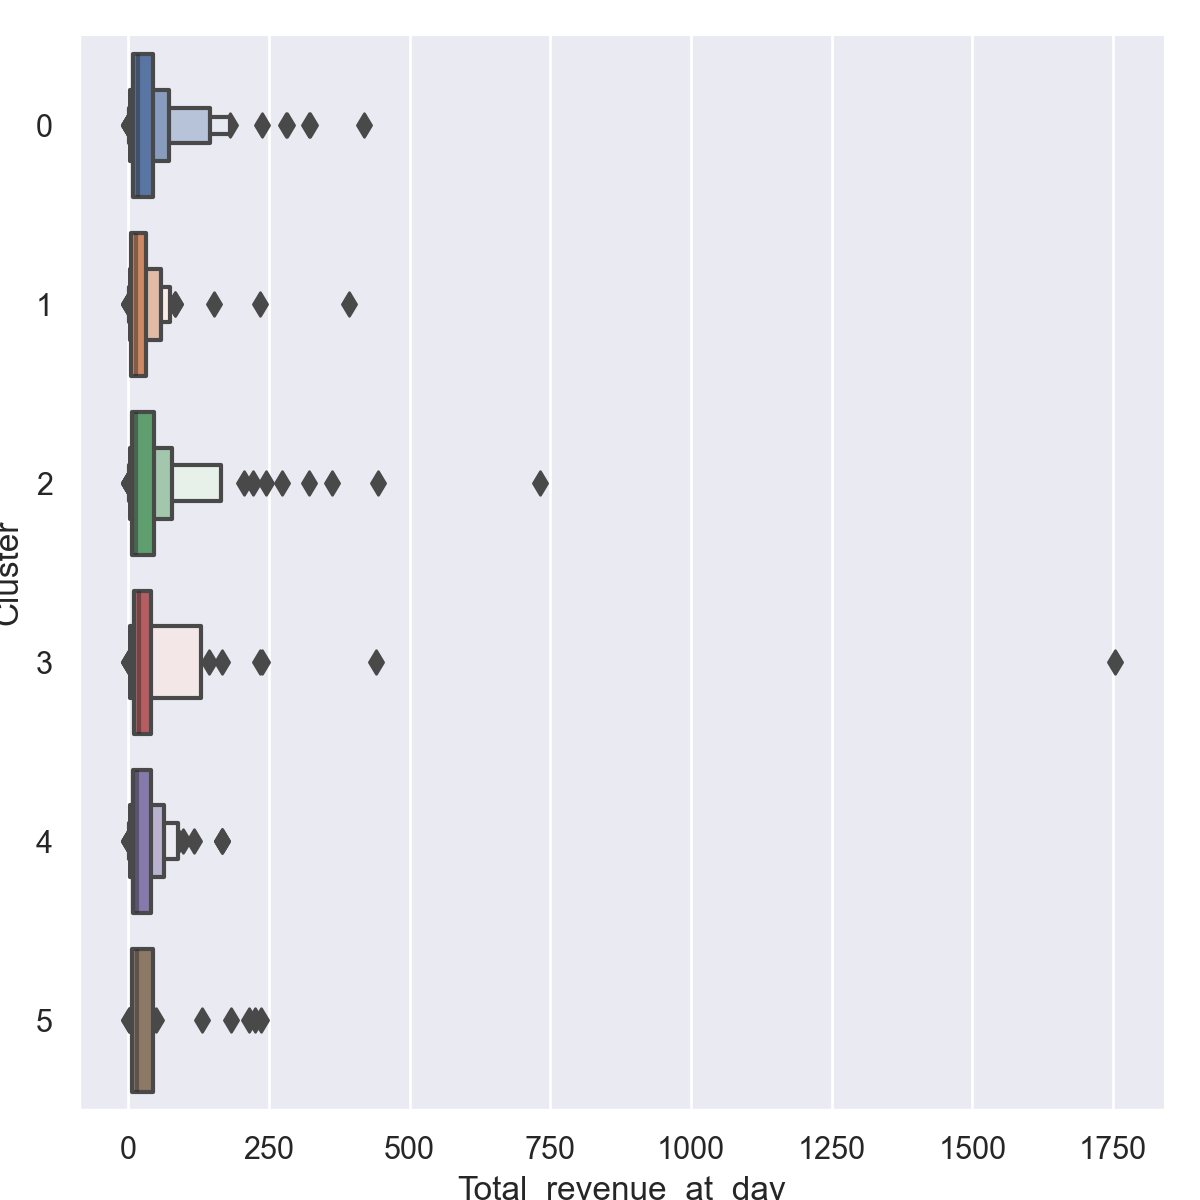

In [357]:
sb.catplot(x="Total_revenue_at_day", y="Cluster", data=X_merged_with_target, kind="boxen", height=6)
plt.show()

In [375]:
print("The 10th percential of the target is: {:.3f}".format(np.percentile(X_merged_with_target["Total_revenue_at_day"], 10)))
print("The 90th percential of the target is: {:.3f}".format(np.percentile(X_merged_with_target["Total_revenue_at_day"], 90)))

The 10th percential of the target is: 2.033
The 90th percential of the target is: 85.403


In [381]:
print(len(X_merged_with_target[X_merged_with_target['Cluster'] == 5]['Total_revenue_at_day']))
np.percentile(X_merged_with_target[X_merged_with_target['Cluster'] == 5]['Total_revenue_at_day'], 10)

27


2.08152

In [382]:
print(len(X_merged_with_target[X_merged_with_target['Cluster'] == 5]['Total_revenue_at_day']))
np.percentile(X_merged_with_target[X_merged_with_target['Cluster'] == 5]['Total_revenue_at_day'], 90)

27


195.60854000000006

In [290]:
start_time = time.time()
dbscan = DBSCAN(eps=0.3)
X["Cluster_DBscan"] = dbscan.fit_predict(X[['level', 'Last_30D_Gross_Sink', 'Life_Time_Login_Days']])
X["Cluster_DBscan"] = X["Cluster_DBscan"].astype("category")
end_time = time.time()
print(end_time - start_time)

<ipython-input-290-19f3fd15e0a7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Cluster_DBscan"] = dbscan.fit_predict(X[['level', 'Last_30D_Gross_Sink', 'Life_Time_Login_Days']])
<ipython-input-290-19f3fd15e0a7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Cluster_DBscan"] = X["Cluster_DBscan"].astype("category")


<IPython.core.display.Javascript object>


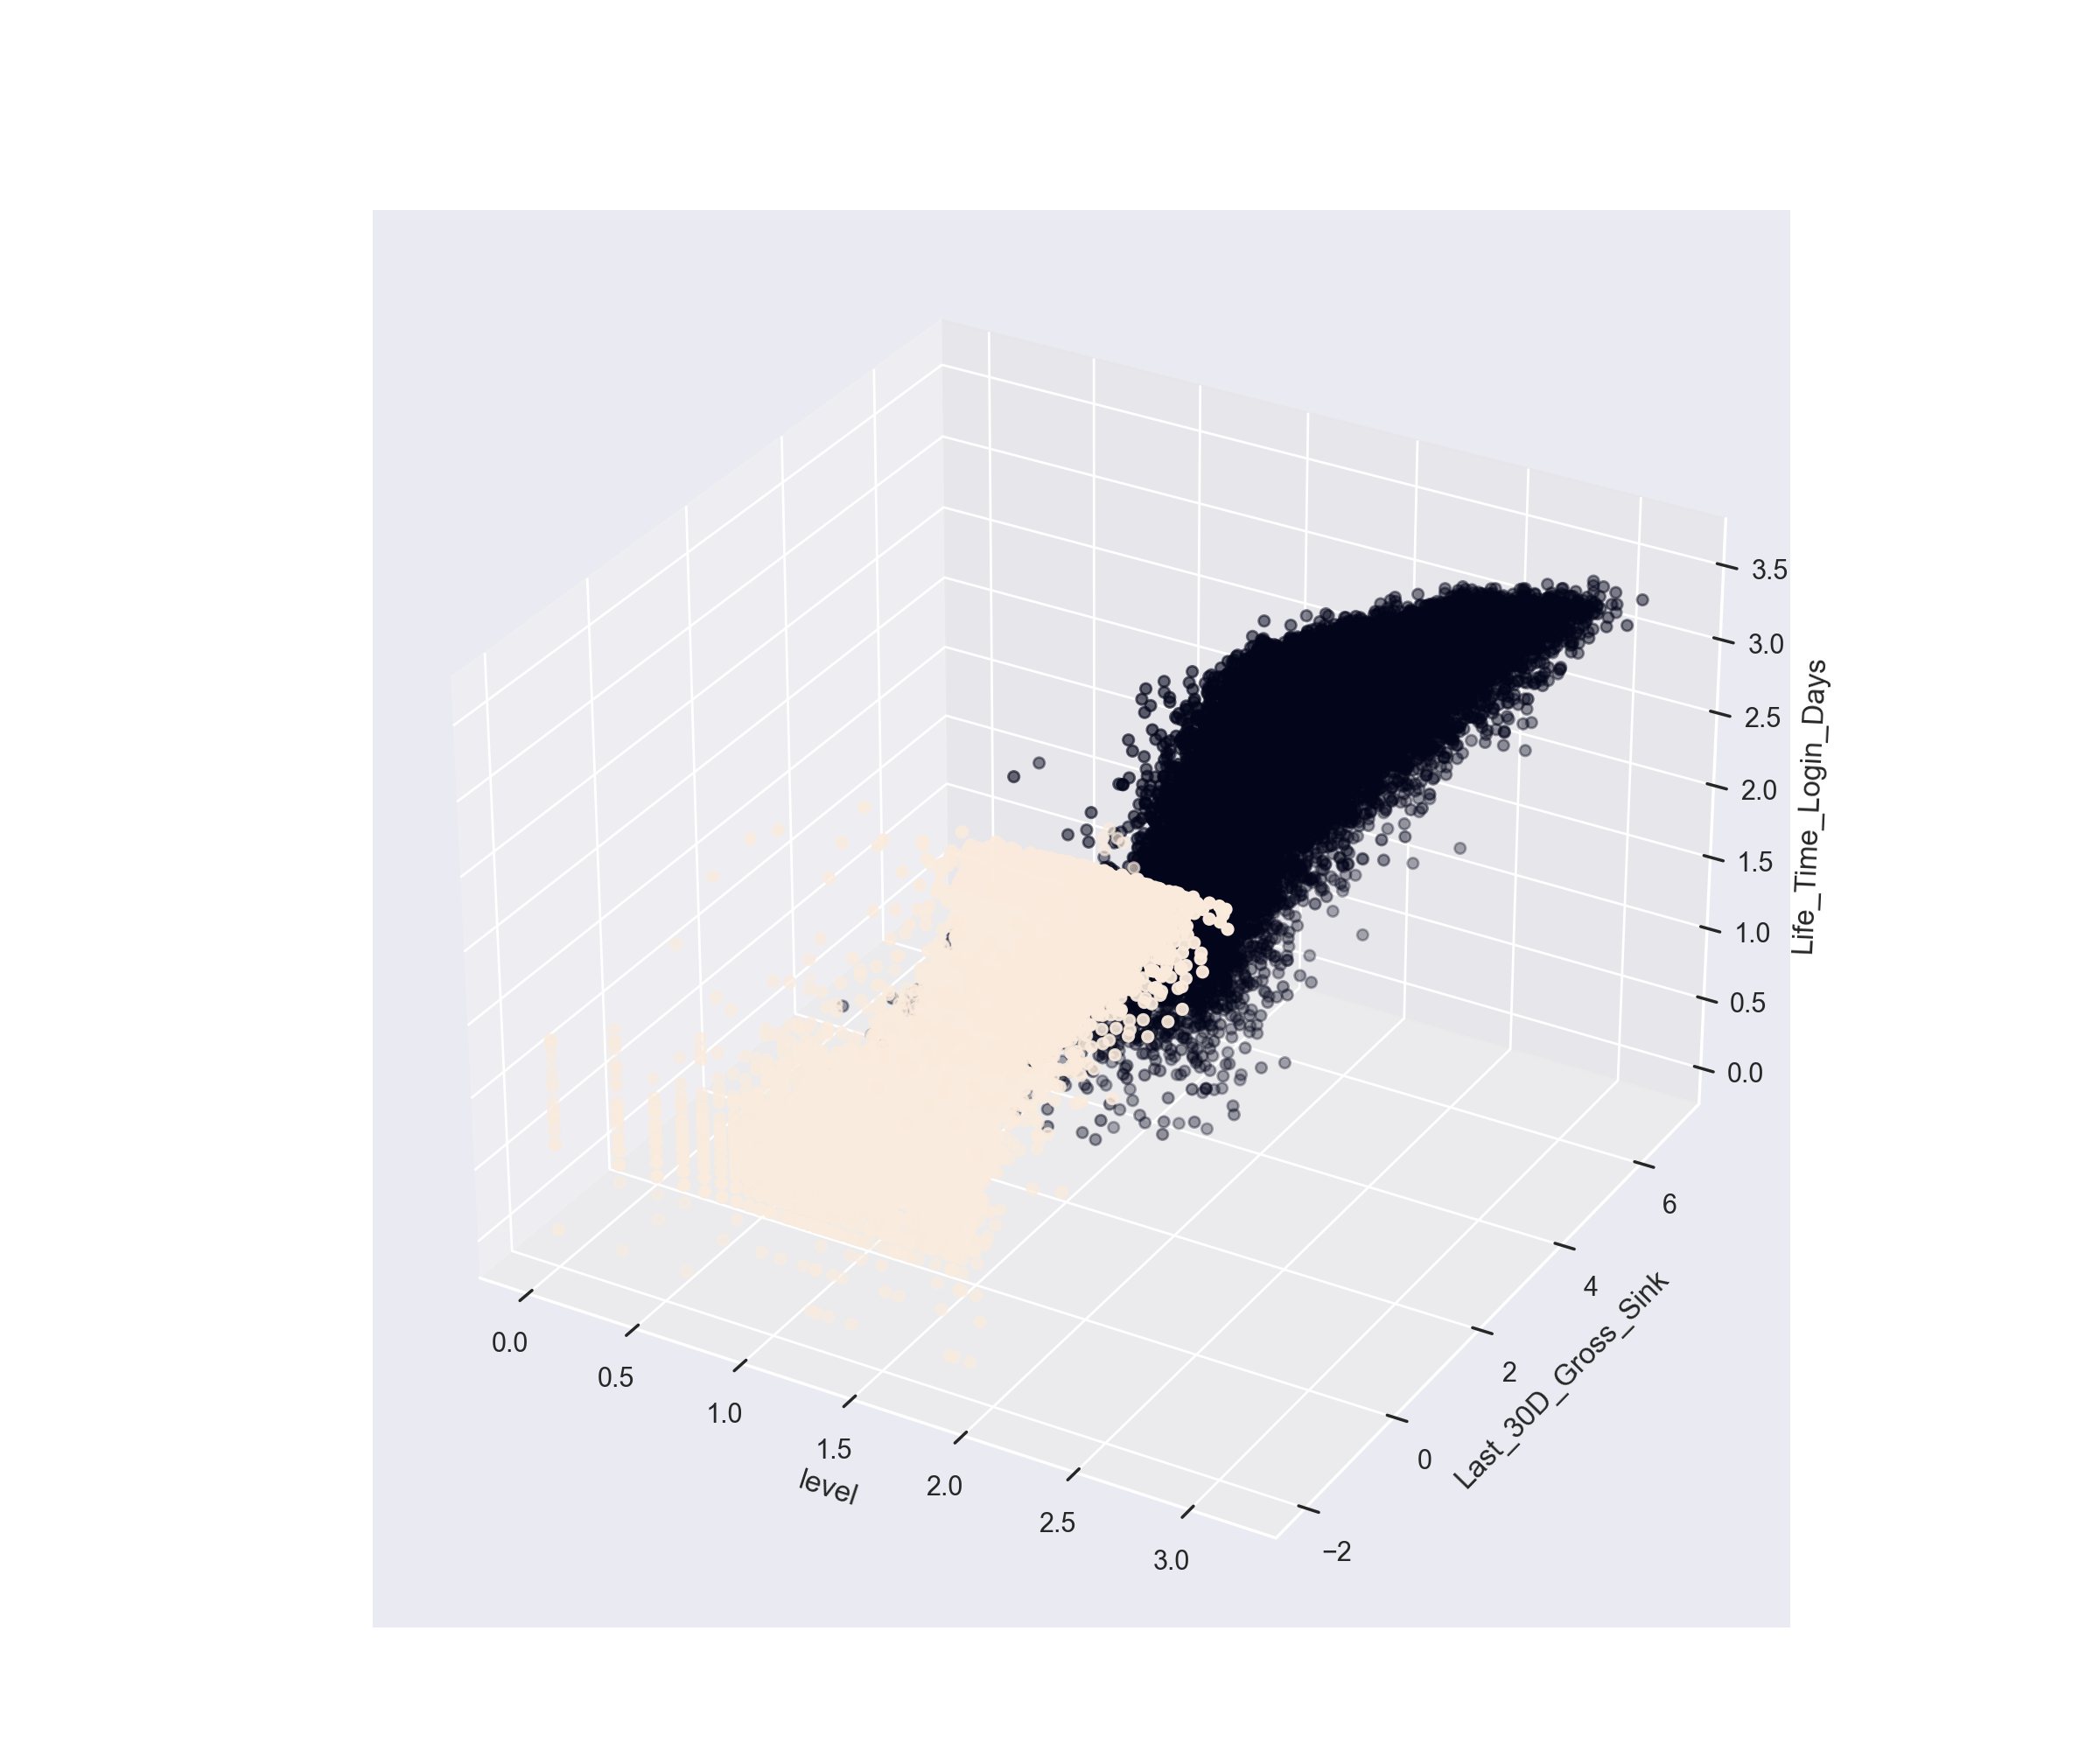

In [292]:
sb.set(style = "darkgrid")

fig = plt.figure(figsize = (12, 10))
ax = Axes3D(fig)
ax = fig.add_subplot(111, projection = '3d')

x = X['level']
y = X['Last_30D_Gross_Sink']
z = X['Life_Time_Login_Days']

ax.set_xlabel("level")
ax.set_ylabel("Last_30D_Gross_Sink")
ax.set_zlabel("Life_Time_Login_Days")

ax.scatter(x, y, z, c = X['Cluster'])

plt.show()